# 07 - Machine Learning Models (LightGBM)

This notebook trains and evaluates ML models for traffic prediction:

1. **LightGBM** - Gradient boosting with feature engineering
2. **Optuna Tuning** - Bayesian hyperparameter optimization
3. **SHAP Analysis** - Model interpretability
4. **Final Comparison** - All models comparison

In [1]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# ML imports
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Project imports
from src.models.lgbm_model import LGBMModel, LGBMConfig
from src.utils.metrics import evaluate_forecast, compare_models, print_metrics

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"Project root: {project_root}")

Importing plotly failed. Interactive plots will not work.


Project root: c:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Data

In [2]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = project_root / "models"
MODELS_DIR.mkdir(exist_ok=True)

# Load feature-engineered data
df_train = pd.read_parquet(PROCESSED_DIR / "train_features_5m.parquet")
df_test = pd.read_parquet(PROCESSED_DIR / "test_features_5m.parquet")

# Load feature info
with open(PROCESSED_DIR / "feature_info.json", 'r') as f:
    feature_info = json.load(f)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (15264, 98)
Test shape: (2592, 98)


In [3]:
# Define target and features
TARGET = 'request_count'

# Exclude non-feature columns
# IMPORTANT: Also exclude 'request_count_pct_of_max' - DATA LEAKAGE (r=1.0 with target!)
exclude_cols = [
    'timestamp', 
    'time_of_day', 
    'part_of_day', 
    TARGET,
    'request_count_pct_of_max',  # DATA LEAKAGE - derived from target, correlation = 1.0!
]

# Get numeric features
feature_cols = [c for c in df_train.select_dtypes(include=[np.number]).columns 
                if c not in exclude_cols]

print(f"Target: {TARGET}")
print(f"Features: {len(feature_cols)}")
print(f"\n⚠️ Removed 'request_count_pct_of_max' to prevent data leakage")
print(f"\nFirst 20 features: {feature_cols[:20]}")

Target: request_count
Features: 91

⚠️ Removed 'request_count_pct_of_max' to prevent data leakage

First 20 features: ['unique_hosts', 'error_count', 'error_rate', 'success_rate', 'bytes_total', 'bytes_avg', 'bytes_max', 'requests_per_host', 'bytes_per_request', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend', 'is_business_hour', 'is_peak_hour']


In [4]:
# Prepare train/val/test splits
# Use last 20% of training for validation
val_size = int(len(df_train) * 0.2)

X_train_full = df_train[feature_cols]
y_train_full = df_train[TARGET]

X_train = X_train_full.iloc[:-val_size]
y_train = y_train_full.iloc[:-val_size]

X_val = X_train_full.iloc[-val_size:]
y_val = y_train_full.iloc[-val_size:]

X_test = df_test[feature_cols]
y_test = df_test[TARGET]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (12212, 91)
X_val shape: (3052, 91)
X_test shape: (2592, 91)


In [5]:
# Handle any NaN values
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

print(f"NaN in X_train: {X_train.isna().sum().sum()}")
print(f"NaN in X_val: {X_val.isna().sum().sum()}")
print(f"NaN in X_test: {X_test.isna().sum().sum()}")

NaN in X_train: 0
NaN in X_val: 0
NaN in X_test: 0


## 1.5 Data Scaling (RobustScaler)

RobustScaler uses median and IQR - more robust to outliers than StandardScaler.
NASA traffic data has spikes, so RobustScaler is preferred.

In [6]:
# Check for inf/nan values before scaling
print("Checking for inf/nan values...")
print(f"X_train - inf: {np.isinf(X_train).sum().sum()}, nan: {np.isnan(X_train).sum().sum()}")
print(f"X_val - inf: {np.isinf(X_val).sum().sum()}, nan: {np.isnan(X_val).sum().sum()}")
print(f"X_test - inf: {np.isinf(X_test).sum().sum()}, nan: {np.isnan(X_test).sum().sum()}")

# Replace inf with large finite values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill any remaining NaN with median
X_train.fillna(X_train.median(), inplace=True)
X_val.fillna(X_train.median(), inplace=True)
X_test.fillna(X_train.median(), inplace=True)

print(f"\nAfter cleaning:")
print(f"X_train - inf: {np.isinf(X_train).sum().sum()}, nan: {np.isnan(X_train).sum().sum()}")
print(f"X_val - inf: {np.isinf(X_val).sum().sum()}, nan: {np.isnan(X_val).sum().sum()}")
print(f"X_test - inf: {np.isinf(X_test).sum().sum()}, nan: {np.isnan(X_test).sum().sum()}")

Checking for inf/nan values...
X_train - inf: 1552, nan: 0
X_val - inf: 54, nan: 0
X_test - inf: 12, nan: 0

After cleaning:
X_train - inf: 0, nan: 0
X_val - inf: 0, nan: 0
X_test - inf: 0, nan: 0


In [7]:
# ============================================================
# DATA SCALING - RobustScaler
# ============================================================
from sklearn.preprocessing import RobustScaler
import joblib

print("=" * 60)
print("DATA SCALING WITH ROBUSTSCALER")
print("=" * 60)

print("\n📊 Why RobustScaler?")
print("- StandardScaler: Uses mean & std → sensitive to outliers")
print("- RobustScaler: Uses median & IQR → robust to outliers")
print("- NASA traffic has spikes → RobustScaler is preferred")

# Initialize scaler
scaler = RobustScaler()

# IMPORTANT: Fit on TRAIN data only, transform all
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (keep column names for feature importance)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

# Save scaler for production use
scaler_path = MODELS_DIR / 'feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"\n✅ Scaler saved to: {scaler_path}")

# Verify scaling
print(f"\n📈 Scaling Statistics:")
print(f"   Train - mean: {X_train_scaled.mean().mean():.4f}, std: {X_train_scaled.std().mean():.4f}")
print(f"   Val   - mean: {X_val_scaled.mean().mean():.4f}, std: {X_val_scaled.std().mean():.4f}")
print(f"   Test  - mean: {X_test_scaled.mean().mean():.4f}, std: {X_test_scaled.std().mean():.4f}")

print(f"\n✅ Data scaling complete!")

DATA SCALING WITH ROBUSTSCALER

📊 Why RobustScaler?
- StandardScaler: Uses mean & std → sensitive to outliers
- RobustScaler: Uses median & IQR → robust to outliers
- NASA traffic has spikes → RobustScaler is preferred

✅ Scaler saved to: c:\Users\Admin\OneDrive\Documents\python\datafollow\models\feature_scaler.pkl

📈 Scaling Statistics:
   Train - mean: 0.1206, std: 1.8180
   Val   - mean: 0.1302, std: 1.2030
   Test  - mean: 0.1743, std: 0.9062

✅ Data scaling complete!


## 2. LightGBM Baseline

In [8]:
# ============================================================
# LightGBM Configuration - STRONG REGULARIZATION
# ============================================================
# Changes from original to prevent overfitting:
# - num_leaves: 31 → 20 (reduce complexity)
# - max_depth: -1 → 6 (limit tree depth)
# - min_child_samples: 20 → 50 (more samples per leaf)
# - learning_rate: 0.05 → 0.02 (slower learning)
# - reg_alpha: 0.1 → 0.5 (stronger L1)
# - reg_lambda: 0.1 → 2.0 (stronger L2)
# - subsample: 0.8 → 0.7 (more randomness)

lgbm_config = LGBMConfig(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    
    # Model complexity - REDUCED
    num_leaves=20,              # 31 → 20
    max_depth=6,                # -1 → 6 (limit depth!)
    min_child_samples=50,       # 20 → 50
    
    # Learning
    learning_rate=0.02,         # 0.05 → 0.02 (slower)
    n_estimators=1500,          # 1000 → 1500 (compensate for lower LR)
    
    # Regularization - STRONG
    reg_alpha=0.5,              # 0.1 → 0.5 (L1)
    reg_lambda=2.0,             # 0.1 → 2.0 (L2)
    
    # Subsampling
    subsample=0.7,              # 0.8 → 0.7
    subsample_freq=1,           # Enable per-iteration subsampling
    colsample_bytree=0.7,       # 0.8 → 0.7
    
    random_state=42,
    early_stopping_rounds=100,  # 50 → 100 (more patience)
)

print("LightGBM Configuration (REGULARIZED):")
for key, value in lgbm_config.to_dict().items():
    print(f"  {key}: {value}")

LightGBM Configuration (REGULARIZED):
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 20
  max_depth: 6
  min_child_samples: 50
  learning_rate: 0.02
  n_estimators: 1500
  reg_alpha: 0.5
  reg_lambda: 2.0
  min_split_gain: 0.0
  subsample: 0.7
  subsample_freq: 1
  colsample_bytree: 0.7
  max_bin: 255
  min_data_in_bin: 3
  random_state: 42
  n_jobs: -1
  verbose: -1
  device: cpu


In [9]:
# Train baseline LightGBM with SCALED data
print("Training LightGBM baseline model with SCALED data...")

lgbm_baseline = LGBMModel(lgbm_config)
lgbm_baseline.fit(
    X_train_scaled, y_train,           # Using scaled data!
    X_val=X_val_scaled, y_val=y_val,   # Using scaled data!
    verbose=True
)

Training LightGBM baseline model with SCALED data...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 18.0894
[200]	valid_0's rmse: 6.88441
[300]	valid_0's rmse: 5.15161
[400]	valid_0's rmse: 4.74989
[500]	valid_0's rmse: 4.52393
[600]	valid_0's rmse: 4.36347
[700]	valid_0's rmse: 4.26483
[800]	valid_0's rmse: 4.19886
[900]	valid_0's rmse: 4.12285
[1000]	valid_0's rmse: 4.06842
[1100]	valid_0's rmse: 4.03479
[1200]	valid_0's rmse: 3.99837
[1300]	valid_0's rmse: 3.94759
[1400]	valid_0's rmse: 3.91798
[1500]	valid_0's rmse: 3.89313
Did not meet early stopping. Best iteration is:
[1500]	valid_0's rmse: 3.89313
Best iteration: 1500


In [10]:
# Evaluate baseline on validation (using scaled data)
val_pred_baseline = lgbm_baseline.predict(X_val_scaled)
val_metrics_baseline = evaluate_forecast(y_val.values, val_pred_baseline, name="LightGBM Baseline (Val)")
print_metrics(val_metrics_baseline)


Model: LightGBM Baseline (Val)
----------------------------------------
  RMSE:  3.8931
  MSE:   15.1565
  MAE:   2.5738
  MAPE:  3.57%
  sMAPE: 2.95%
  R2:    0.9984


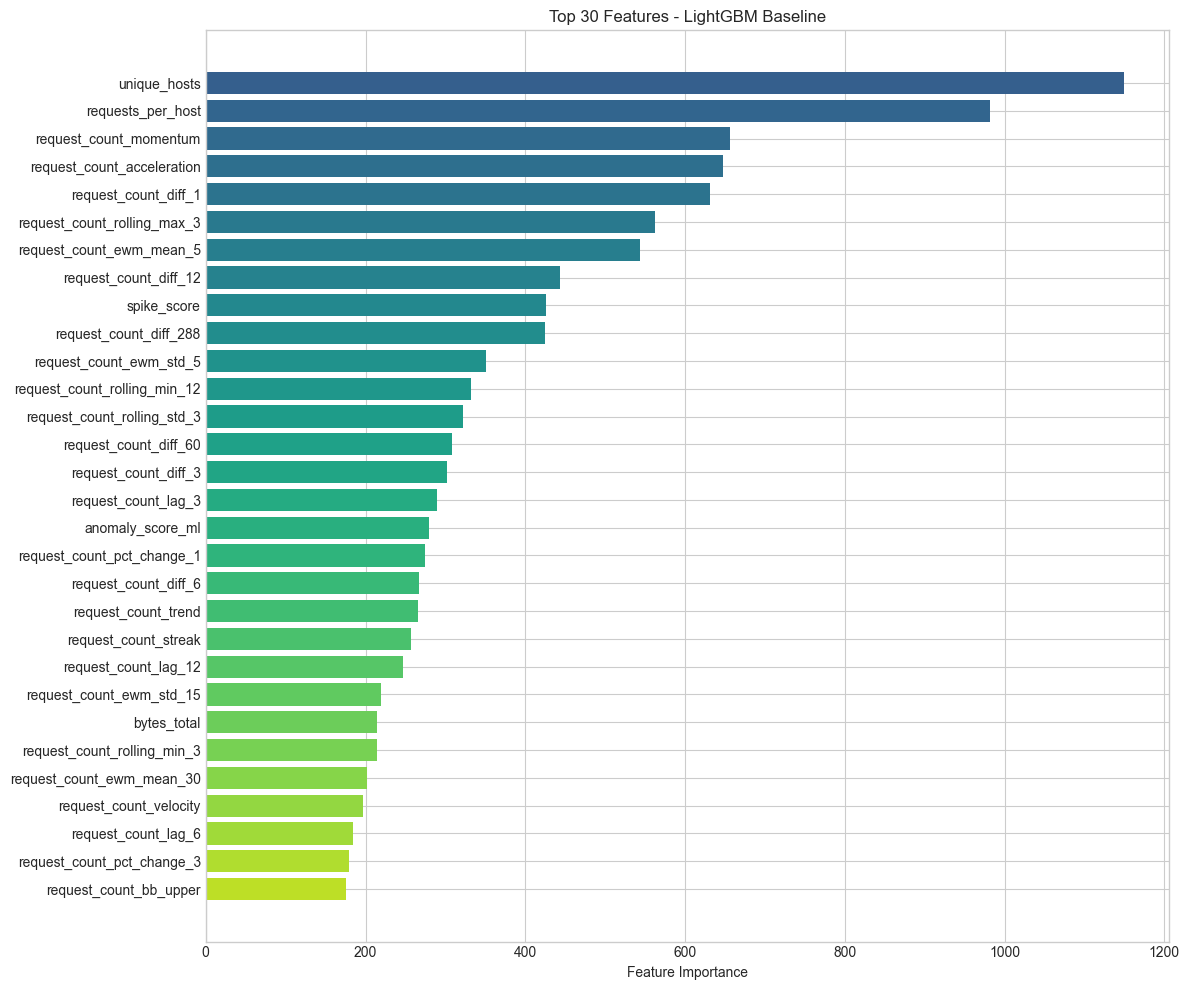

In [11]:
# Feature importance (baseline)
importance_baseline = lgbm_baseline.get_feature_importance()

fig, ax = plt.subplots(figsize=(12, 10))
top30 = importance_baseline.head(30)
ax.barh(range(len(top30)), top30['importance'], color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top30))))
ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 30 Features - LightGBM Baseline')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Hyperparameter Tuning with Optuna

In [12]:
# Check if Optuna is available and run hyperparameter tuning
try:
    import optuna
    from sklearn.metrics import mean_squared_error
    import lightgbm as lgb
    OPTUNA_AVAILABLE = True
    print("Optuna is available for hyperparameter tuning")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not installed. Install with: pip install optuna")
    print("Using default parameters instead...")

Optuna is available for hyperparameter tuning


In [13]:
# Run Optuna hyperparameter tuning with STRONG REGULARIZATION
if OPTUNA_AVAILABLE:
    print("=" * 60)
    print("OPTUNA HYPERPARAMETER TUNING")
    print("=" * 60)
    print("\nKey changes to prevent overfitting:")
    print("  - num_leaves: max 100 (was unlimited)")
    print("  - max_depth: max 10 (was unlimited)")
    print("  - reg_alpha: min 1.0 (was 1e-8)")
    print("  - reg_lambda: min 1.0 (was 1e-8)")
    
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'random_state': 42,
            
            # Model complexity - CONSTRAINED
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),        # Max 100
            'max_depth': trial.suggest_int('max_depth', 3, 10),            # Max 10
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            
            # Learning rate
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            
            # STRONG REGULARIZATION - KEY CHANGE!
            'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0),      # Min 1.0!
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0),    # Min 1.0!
            
            # Subsampling for additional regularization
            'subsample': trial.suggest_float('subsample', 0.5, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
            
            'n_estimators': 500,
        }
        
        # Train model with early stopping
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train_scaled, y_train,
            eval_set=[(X_val_scaled, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False), lgb.log_evaluation(0)]
        )
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val_scaled)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        return val_rmse
    
    # Create study with TPE sampler
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    print("\nStarting Optuna tuning with 100 trials...")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    
    print("\n" + "=" * 60)
    print("OPTUNA RESULTS")
    print("=" * 60)
    print(f"\nBest validation RMSE: {study.best_value:.2f}")
    print("\nBest parameters:")
    best_params = study.best_params.copy()
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    # Verify regularization is strong
    print(f"\nRegularization check:")
    print(f"  reg_alpha >= 1.0: {best_params.get('reg_alpha', 0) >= 1.0}")
    print(f"  reg_lambda >= 1.0: {best_params.get('reg_lambda', 0) >= 1.0}")
    
else:
    # Default params with STRONG regularization if Optuna not available
    print("Using default parameters with STRONG regularization")
    best_params = {
        'num_leaves': 31,
        'max_depth': 6,
        'min_child_samples': 50,
        'learning_rate': 0.03,
        'reg_alpha': 10.0,         # STRONG L1
        'reg_lambda': 10.0,        # STRONG L2
        'subsample': 0.7,
        'colsample_bytree': 0.7,
    }
    print("\nDefault parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

[I 2026-02-02 12:29:13,784] A new study created in memory with name: no-name-1d4a5791-3921-405f-8dc4-88bd1c024309


OPTUNA HYPERPARAMETER TUNING

Key changes to prevent overfitting:
  - num_leaves: max 100 (was unlimited)
  - max_depth: max 10 (was unlimited)
  - reg_alpha: min 1.0 (was 1e-8)
  - reg_lambda: min 1.0 (was 1e-8)

Starting Optuna tuning with 100 trials...


Best trial: 0. Best value: 4.00386:   1%|          | 1/100 [00:01<02:51,  1.73s/it]

[I 2026-02-02 12:29:15,512] Trial 0 finished with value: 4.003861277029881 and parameters: {'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 79, 'learning_rate': 0.03968793330444373, 'reg_alpha': 8.64491338167939, 'reg_lambda': 8.64373149647393, 'subsample': 0.5232334448672797, 'colsample_bytree': 0.846470458309974}. Best is trial 0 with value: 4.003861277029881.


Best trial: 1. Best value: 3.95728:   2%|▏         | 2/100 [00:03<02:37,  1.61s/it]

[I 2026-02-02 12:29:17,035] Trial 1 finished with value: 3.957281414478548 and parameters: {'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 21, 'learning_rate': 0.09330606024425668, 'reg_alpha': 41.78968939922066, 'reg_lambda': 11.404616423235531, 'subsample': 0.5727299868828403, 'colsample_bytree': 0.5733618039413735}. Best is trial 1 with value: 3.957281414478548.


Best trial: 1. Best value: 3.95728:   3%|▎         | 3/100 [00:04<02:30,  1.55s/it]

[I 2026-02-02 12:29:18,520] Trial 2 finished with value: 4.29403558063588 and parameters: {'num_leaves': 37, 'max_depth': 7, 'min_child_samples': 54, 'learning_rate': 0.019553708662745254, 'reg_alpha': 30.980791841396595, 'reg_lambda': 7.83519917195005, 'subsample': 0.6168578594140872, 'colsample_bytree': 0.6465447373174766}. Best is trial 1 with value: 3.957281414478548.


Best trial: 3. Best value: 3.7991:   4%|▍         | 4/100 [00:06<02:34,  1.61s/it] 

[I 2026-02-02 12:29:20,213] Trial 3 finished with value: 3.799099958591014 and parameters: {'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 36, 'learning_rate': 0.032676417657817626, 'reg_alpha': 30.02831387424008, 'reg_lambda': 3.2760702232798886, 'subsample': 0.7430179407605754, 'colsample_bytree': 0.5682096494749166}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:   5%|▌         | 5/100 [00:07<02:12,  1.40s/it]

[I 2026-02-02 12:29:21,244] Trial 4 finished with value: 4.360056041558494 and parameters: {'num_leaves': 15, 'max_depth': 10, 'min_child_samples': 98, 'learning_rate': 0.06432759992849894, 'reg_alpha': 15.926074689495163, 'reg_lambda': 5.78593358631281, 'subsample': 0.7736932106048628, 'colsample_bytree': 0.6760609974958405}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:   6%|▌         | 6/100 [00:08<01:56,  1.23s/it]

[I 2026-02-02 12:29:22,160] Trial 5 finished with value: 4.0708479542204365 and parameters: {'num_leaves': 21, 'max_depth': 6, 'min_child_samples': 22, 'learning_rate': 0.08115595675970502, 'reg_alpha': 13.68021909840083, 'reg_lambda': 33.463591933345114, 'subsample': 0.6246844304357644, 'colsample_bytree': 0.7080272084711243}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:   7%|▋         | 7/100 [00:09<01:37,  1.05s/it]

[I 2026-02-02 12:29:22,837] Trial 6 finished with value: 5.322885137427881 and parameters: {'num_leaves': 59, 'max_depth': 4, 'min_child_samples': 98, 'learning_rate': 0.05958443469672518, 'reg_alpha': 47.035448136645265, 'reg_lambda': 44.84654017095479, 'subsample': 0.739159991524434, 'colsample_bytree': 0.8687496940092467}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:   8%|▊         | 8/100 [00:09<01:29,  1.03it/s]

[I 2026-02-02 12:29:23,633] Trial 7 finished with value: 4.978039813621068 and parameters: {'num_leaves': 18, 'max_depth': 4, 'min_child_samples': 23, 'learning_rate': 0.0211509720216856, 'reg_alpha': 20.045187194784617, 'reg_lambda': 14.2961025569209, 'subsample': 0.8314950036607718, 'colsample_bytree': 0.6427013306774357}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:   9%|▉         | 9/100 [00:10<01:27,  1.05it/s]

[I 2026-02-02 12:29:24,558] Trial 8 finished with value: 4.4116594054279625 and parameters: {'num_leaves': 35, 'max_depth': 7, 'min_child_samples': 31, 'learning_rate': 0.0634157277549528, 'reg_alpha': 4.652981540308771, 'reg_lambda': 49.35745989342535, 'subsample': 0.808897907718663, 'colsample_bytree': 0.5794862726136689}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  10%|█         | 10/100 [00:11<01:21,  1.10it/s]

[I 2026-02-02 12:29:25,362] Trial 9 finished with value: 4.9097197148080785 and parameters: {'num_leaves': 10, 'max_depth': 9, 'min_child_samples': 77, 'learning_rate': 0.05358055009231865, 'reg_alpha': 38.79224698761134, 'reg_lambda': 4.628187934970428, 'subsample': 0.6433862914177091, 'colsample_bytree': 0.5463476238100519}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  11%|█         | 11/100 [00:13<01:35,  1.07s/it]

[I 2026-02-02 12:29:26,800] Trial 10 finished with value: 6.218421062235599 and parameters: {'num_leaves': 93, 'max_depth': 6, 'min_child_samples': 44, 'learning_rate': 0.010422259339479684, 'reg_alpha': 28.715041443388756, 'reg_lambda': 21.913831873782403, 'subsample': 0.8839082983781679, 'colsample_bytree': 0.5047410382446582}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  12%|█▏        | 12/100 [00:14<01:50,  1.26s/it]

[I 2026-02-02 12:29:28,479] Trial 11 finished with value: 3.898596250297075 and parameters: {'num_leaves': 69, 'max_depth': 8, 'min_child_samples': 38, 'learning_rate': 0.027934773174073776, 'reg_alpha': 40.11531359594251, 'reg_lambda': 18.58052857797514, 'subsample': 0.5271281071050484, 'colsample_bytree': 0.7542068590769169}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  13%|█▎        | 13/100 [00:16<01:52,  1.29s/it]

[I 2026-02-02 12:29:29,843] Trial 12 finished with value: 3.998527871103354 and parameters: {'num_leaves': 76, 'max_depth': 8, 'min_child_samples': 41, 'learning_rate': 0.029066142424692763, 'reg_alpha': 35.135442625127084, 'reg_lambda': 26.86116575847156, 'subsample': 0.6874820875551368, 'colsample_bytree': 0.770727223238246}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  14%|█▍        | 14/100 [00:17<01:57,  1.37s/it]

[I 2026-02-02 12:29:31,388] Trial 13 finished with value: 3.840215233310227 and parameters: {'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 43, 'learning_rate': 0.031496925034466786, 'reg_alpha': 49.068039116275436, 'reg_lambda': 19.03315429842686, 'subsample': 0.501380632545722, 'colsample_bytree': 0.7714051475459972}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  15%|█▌        | 15/100 [00:19<01:58,  1.39s/it]

[I 2026-02-02 12:29:32,832] Trial 14 finished with value: 4.075818709984746 and parameters: {'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 56, 'learning_rate': 0.038435521019679016, 'reg_alpha': 49.00852976144576, 'reg_lambda': 30.94888435344216, 'subsample': 0.7048579745628216, 'colsample_bytree': 0.7952393368504931}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  16%|█▌        | 16/100 [00:20<02:01,  1.45s/it]

[I 2026-02-02 12:29:34,410] Trial 15 finished with value: 4.565521190453114 and parameters: {'num_leaves': 100, 'max_depth': 9, 'min_child_samples': 66, 'learning_rate': 0.01817561623214542, 'reg_alpha': 23.163989331002814, 'reg_lambda': 38.15295723364059, 'subsample': 0.6695614566733774, 'colsample_bytree': 0.7210910250313955}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  17%|█▋        | 17/100 [00:21<01:46,  1.28s/it]

[I 2026-02-02 12:29:35,310] Trial 16 finished with value: 4.223018216184407 and parameters: {'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 48, 'learning_rate': 0.043488741947914925, 'reg_alpha': 32.358298072280675, 'reg_lambda': 16.460245966225713, 'subsample': 0.7352092699549956, 'colsample_bytree': 0.8081581353287693}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  18%|█▊        | 18/100 [00:24<02:15,  1.66s/it]

[I 2026-02-02 12:29:37,843] Trial 17 finished with value: 4.102468078582374 and parameters: {'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 33, 'learning_rate': 0.013155226174318376, 'reg_alpha': 44.89940808261725, 'reg_lambda': 2.3337322931686515, 'subsample': 0.5701429934265622, 'colsample_bytree': 0.6103867935467329}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  19%|█▉        | 19/100 [00:24<01:49,  1.35s/it]

[I 2026-02-02 12:29:38,484] Trial 18 finished with value: 6.575068561498673 and parameters: {'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 62, 'learning_rate': 0.025034945279002036, 'reg_alpha': 26.58857392950896, 'reg_lambda': 25.832036586711688, 'subsample': 0.8991170059722473, 'colsample_bytree': 0.8918264577139728}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  20%|██        | 20/100 [00:26<02:02,  1.54s/it]

[I 2026-02-02 12:29:40,452] Trial 19 finished with value: 3.9513118503882336 and parameters: {'num_leaves': 29, 'max_depth': 9, 'min_child_samples': 32, 'learning_rate': 0.01567151617348874, 'reg_alpha': 21.005788483608104, 'reg_lambda': 18.1060943991357, 'subsample': 0.502585728563216, 'colsample_bytree': 0.7315854399505392}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  21%|██        | 21/100 [00:27<01:51,  1.41s/it]

[I 2026-02-02 12:29:41,576] Trial 20 finished with value: 3.9356446846828543 and parameters: {'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 50, 'learning_rate': 0.04601476922512079, 'reg_alpha': 34.12938879690617, 'reg_lambda': 13.156707254150351, 'subsample': 0.8359747909672949, 'colsample_bytree': 0.5216338806350271}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  22%|██▏       | 22/100 [00:29<01:52,  1.44s/it]

[I 2026-02-02 12:29:43,067] Trial 21 finished with value: 3.809103880032841 and parameters: {'num_leaves': 68, 'max_depth': 8, 'min_child_samples': 40, 'learning_rate': 0.031132680920542968, 'reg_alpha': 40.01524372754806, 'reg_lambda': 21.06050673005018, 'subsample': 0.5701681688558512, 'colsample_bytree': 0.752086498204049}. Best is trial 3 with value: 3.799099958591014.


Best trial: 3. Best value: 3.7991:  23%|██▎       | 23/100 [00:30<01:47,  1.39s/it]

[I 2026-02-02 12:29:44,366] Trial 22 finished with value: 3.805060212504309 and parameters: {'num_leaves': 88, 'max_depth': 7, 'min_child_samples': 38, 'learning_rate': 0.03356871468526653, 'reg_alpha': 37.69583916756438, 'reg_lambda': 23.527694181828213, 'subsample': 0.5834054919612813, 'colsample_bytree': 0.8229638679949765}. Best is trial 3 with value: 3.799099958591014.


Best trial: 23. Best value: 3.6886:  24%|██▍       | 24/100 [00:32<01:47,  1.42s/it]

[I 2026-02-02 12:29:45,827] Trial 23 finished with value: 3.688596005454082 and parameters: {'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 28, 'learning_rate': 0.03497690819009142, 'reg_alpha': 37.004123436774165, 'reg_lambda': 23.26098876311764, 'subsample': 0.5738080985777567, 'colsample_bytree': 0.8383630770096759}. Best is trial 23 with value: 3.688596005454082.


Best trial: 23. Best value: 3.6886:  25%|██▌       | 25/100 [00:33<01:50,  1.48s/it]

[I 2026-02-02 12:29:47,444] Trial 24 finished with value: 4.06381323273728 and parameters: {'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 29, 'learning_rate': 0.02487099853953923, 'reg_alpha': 35.266232739669384, 'reg_lambda': 36.65914012988932, 'subsample': 0.5966292934546618, 'colsample_bytree': 0.8258748045213946}. Best is trial 23 with value: 3.688596005454082.


Best trial: 23. Best value: 3.6886:  26%|██▌       | 26/100 [00:34<01:45,  1.43s/it]

[I 2026-02-02 12:29:48,756] Trial 25 finished with value: 3.8967634256161383 and parameters: {'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 27, 'learning_rate': 0.037242308794820954, 'reg_alpha': 26.571959624669276, 'reg_lambda': 29.196565473960156, 'subsample': 0.6527998447162596, 'colsample_bytree': 0.8997653976350741}. Best is trial 23 with value: 3.688596005454082.


Best trial: 23. Best value: 3.6886:  27%|██▋       | 27/100 [00:36<01:35,  1.31s/it]

[I 2026-02-02 12:29:49,804] Trial 26 finished with value: 4.160072211984818 and parameters: {'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 36, 'learning_rate': 0.052027512735523744, 'reg_alpha': 43.649887971154016, 'reg_lambda': 23.741321963343953, 'subsample': 0.7298640198998795, 'colsample_bytree': 0.8465144231638824}. Best is trial 23 with value: 3.688596005454082.


Best trial: 23. Best value: 3.6886:  28%|██▊       | 28/100 [00:37<01:34,  1.31s/it]

[I 2026-02-02 12:29:51,095] Trial 27 finished with value: 4.146594918865469 and parameters: {'num_leaves': 50, 'max_depth': 7, 'min_child_samples': 48, 'learning_rate': 0.03524699140222362, 'reg_alpha': 37.48647420171454, 'reg_lambda': 38.538982087256926, 'subsample': 0.7671548669766161, 'colsample_bytree': 0.814619002069142}. Best is trial 23 with value: 3.688596005454082.


Best trial: 23. Best value: 3.6886:  29%|██▉       | 29/100 [00:38<01:25,  1.21s/it]

[I 2026-02-02 12:29:52,070] Trial 28 finished with value: 4.6335645300823085 and parameters: {'num_leaves': 61, 'max_depth': 5, 'min_child_samples': 26, 'learning_rate': 0.023806747994752662, 'reg_alpha': 30.09605406412852, 'reg_lambda': 32.20138674491279, 'subsample': 0.5506090757484944, 'colsample_bytree': 0.6795014081094666}. Best is trial 23 with value: 3.688596005454082.


Best trial: 23. Best value: 3.6886:  30%|███       | 30/100 [00:40<01:40,  1.43s/it]

[I 2026-02-02 12:29:54,022] Trial 29 finished with value: 3.9714186451829527 and parameters: {'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 68, 'learning_rate': 0.041489287082762075, 'reg_alpha': 23.648638579151857, 'reg_lambda': 1.0927172386625195, 'subsample': 0.6098597513574386, 'colsample_bytree': 0.8586370863687315}. Best is trial 23 with value: 3.688596005454082.


Best trial: 23. Best value: 3.6886:  31%|███       | 31/100 [00:41<01:31,  1.33s/it]

[I 2026-02-02 12:29:55,102] Trial 30 finished with value: 4.120610139497222 and parameters: {'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 35, 'learning_rate': 0.05007273069197879, 'reg_alpha': 37.23606401411652, 'reg_lambda': 9.280372285324725, 'subsample': 0.6957897446483623, 'colsample_bytree': 0.6313581602712913}. Best is trial 23 with value: 3.688596005454082.


Best trial: 23. Best value: 3.6886:  32%|███▏      | 32/100 [00:42<01:35,  1.41s/it]

[I 2026-02-02 12:29:56,694] Trial 31 finished with value: 3.896724963407354 and parameters: {'num_leaves': 69, 'max_depth': 8, 'min_child_samples': 38, 'learning_rate': 0.03207737901307037, 'reg_alpha': 42.433894341842915, 'reg_lambda': 22.153752212172403, 'subsample': 0.5437315742230482, 'colsample_bytree': 0.7845345989728906}. Best is trial 23 with value: 3.688596005454082.


Best trial: 32. Best value: 3.60883:  33%|███▎      | 33/100 [00:44<01:44,  1.56s/it]

[I 2026-02-02 12:29:58,601] Trial 32 finished with value: 3.608827583095323 and parameters: {'num_leaves': 65, 'max_depth': 7, 'min_child_samples': 20, 'learning_rate': 0.033627792581911266, 'reg_alpha': 41.13377680901479, 'reg_lambda': 21.24819617701008, 'subsample': 0.5950861601038587, 'colsample_bytree': 0.8337009075799446}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  34%|███▍      | 34/100 [00:46<01:52,  1.70s/it]

[I 2026-02-02 12:30:00,638] Trial 33 finished with value: 3.680880881091396 and parameters: {'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 20, 'learning_rate': 0.034431874825306484, 'reg_alpha': 32.66138166692151, 'reg_lambda': 28.20442566847717, 'subsample': 0.5906276097478554, 'colsample_bytree': 0.8319861552496324}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  35%|███▌      | 35/100 [00:48<01:51,  1.72s/it]

[I 2026-02-02 12:30:02,404] Trial 34 finished with value: 3.749908933013423 and parameters: {'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 21, 'learning_rate': 0.02731233279786692, 'reg_alpha': 32.57875529329494, 'reg_lambda': 28.536567509489128, 'subsample': 0.6453425483402667, 'colsample_bytree': 0.8758965965521691}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  36%|███▌      | 36/100 [00:51<02:07,  1.99s/it]

[I 2026-02-02 12:30:05,010] Trial 35 finished with value: 3.834457255421139 and parameters: {'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 20, 'learning_rate': 0.02123760363502486, 'reg_alpha': 33.14870382608833, 'reg_lambda': 29.2902739120531, 'subsample': 0.6385607851672396, 'colsample_bytree': 0.8681547334139107}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  37%|███▋      | 37/100 [00:52<01:54,  1.82s/it]

[I 2026-02-02 12:30:06,430] Trial 36 finished with value: 3.8551063779345323 and parameters: {'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 20, 'learning_rate': 0.027317318342875277, 'reg_alpha': 44.9325325902436, 'reg_lambda': 27.110526183532098, 'subsample': 0.5980989822137767, 'colsample_bytree': 0.8368872576964539}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  38%|███▊      | 38/100 [00:54<01:55,  1.86s/it]

[I 2026-02-02 12:30:08,412] Trial 37 finished with value: 4.103962229661351 and parameters: {'num_leaves': 63, 'max_depth': 7, 'min_child_samples': 25, 'learning_rate': 0.017005091551300634, 'reg_alpha': 30.528385300357783, 'reg_lambda': 35.801392710962645, 'subsample': 0.6217477205627072, 'colsample_bytree': 0.8734008240469703}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  39%|███▉      | 39/100 [00:56<01:49,  1.79s/it]

[I 2026-02-02 12:30:10,036] Trial 38 finished with value: 3.93202163842188 and parameters: {'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 28, 'learning_rate': 0.03935101859872957, 'reg_alpha': 41.26031390090206, 'reg_lambda': 41.3135518605577, 'subsample': 0.5509571071047297, 'colsample_bytree': 0.8408389037876585}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  40%|████      | 40/100 [00:57<01:35,  1.59s/it]

[I 2026-02-02 12:30:11,140] Trial 39 finished with value: 4.741438482221243 and parameters: {'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 91, 'learning_rate': 0.0892972521387558, 'reg_alpha': 14.779675648425007, 'reg_lambda': 34.09040939880858, 'subsample': 0.6670022442112158, 'colsample_bytree': 0.8839495806298302}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  41%|████      | 41/100 [00:58<01:31,  1.55s/it]

[I 2026-02-02 12:30:12,603] Trial 40 finished with value: 3.9064742467110687 and parameters: {'num_leaves': 54, 'max_depth': 6, 'min_child_samples': 24, 'learning_rate': 0.021916961791776036, 'reg_alpha': 28.087406623099458, 'reg_lambda': 28.699812390331594, 'subsample': 0.6282977034916852, 'colsample_bytree': 0.8518729660665979}. Best is trial 32 with value: 3.608827583095323.


Best trial: 32. Best value: 3.60883:  42%|████▏     | 42/100 [01:00<01:26,  1.49s/it]

[I 2026-02-02 12:30:13,955] Trial 41 finished with value: 3.7920564190311388 and parameters: {'num_leaves': 53, 'max_depth': 7, 'min_child_samples': 23, 'learning_rate': 0.03501924743927605, 'reg_alpha': 32.58445137375173, 'reg_lambda': 10.14429423378142, 'subsample': 0.5910282450348977, 'colsample_bytree': 0.5878702735131445}. Best is trial 32 with value: 3.608827583095323.


Best trial: 42. Best value: 3.43581:  43%|████▎     | 43/100 [01:02<01:31,  1.60s/it]

[I 2026-02-02 12:30:15,810] Trial 42 finished with value: 3.4358125450614803 and parameters: {'num_leaves': 52, 'max_depth': 7, 'min_child_samples': 20, 'learning_rate': 0.0719792575712725, 'reg_alpha': 32.046191965660576, 'reg_lambda': 7.410423290894032, 'subsample': 0.5907127321548561, 'colsample_bytree': 0.8002680273778602}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  44%|████▍     | 44/100 [01:03<01:29,  1.61s/it]

[I 2026-02-02 12:30:17,428] Trial 43 finished with value: 3.6918492718401685 and parameters: {'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 20, 'learning_rate': 0.08076690637033286, 'reg_alpha': 35.46387549404779, 'reg_lambda': 14.368418954256073, 'subsample': 0.5650604061734923, 'colsample_bytree': 0.7930910985369748}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  45%|████▌     | 45/100 [01:04<01:21,  1.47s/it]

[I 2026-02-02 12:30:18,596] Trial 44 finished with value: 3.9066010397553987 and parameters: {'num_leaves': 60, 'max_depth': 6, 'min_child_samples': 29, 'learning_rate': 0.08083723737098655, 'reg_alpha': 36.28994932586329, 'reg_lambda': 6.484780442069802, 'subsample': 0.5201398898938246, 'colsample_bytree': 0.8003900269566818}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  46%|████▌     | 46/100 [01:06<01:25,  1.58s/it]

[I 2026-02-02 12:30:20,428] Trial 45 finished with value: 3.517216509771614 and parameters: {'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 20, 'learning_rate': 0.07009251450399998, 'reg_alpha': 39.518417964813025, 'reg_lambda': 13.670737988060388, 'subsample': 0.5645300969479782, 'colsample_bytree': 0.7760848411889918}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  47%|████▋     | 47/100 [01:08<01:23,  1.58s/it]

[I 2026-02-02 12:30:22,019] Trial 46 finished with value: 3.7116716195092656 and parameters: {'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 25, 'learning_rate': 0.06814836038265452, 'reg_alpha': 39.726601351785746, 'reg_lambda': 12.12184282117562, 'subsample': 0.5287761410511714, 'colsample_bytree': 0.7494338910903373}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  48%|████▊     | 48/100 [01:10<01:25,  1.65s/it]

[I 2026-02-02 12:30:23,805] Trial 47 finished with value: 3.753223972953114 and parameters: {'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 32, 'learning_rate': 0.05827767412089566, 'reg_alpha': 46.309634165539904, 'reg_lambda': 8.283691985524593, 'subsample': 0.6082104082148602, 'colsample_bytree': 0.7675185955358931}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  49%|████▉     | 49/100 [01:11<01:23,  1.65s/it]

[I 2026-02-02 12:30:25,460] Trial 48 finished with value: 3.6573893203731447 and parameters: {'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 29, 'learning_rate': 0.06811490555222272, 'reg_alpha': 38.96331091585437, 'reg_lambda': 15.736001590643724, 'subsample': 0.5823622016080106, 'colsample_bytree': 0.8280659166221537}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  50%|█████     | 50/100 [01:13<01:21,  1.63s/it]

[I 2026-02-02 12:30:27,038] Trial 49 finished with value: 3.696306061828508 and parameters: {'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 23, 'learning_rate': 0.09291327346021247, 'reg_alpha': 11.29802098064328, 'reg_lambda': 17.02015087686614, 'subsample': 0.5485391588874261, 'colsample_bytree': 0.7841080712661772}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  51%|█████     | 51/100 [01:14<01:17,  1.59s/it]

[I 2026-02-02 12:30:28,543] Trial 50 finished with value: 4.385735812150466 and parameters: {'num_leaves': 64, 'max_depth': 9, 'min_child_samples': 85, 'learning_rate': 0.06905935826049885, 'reg_alpha': 42.769961728945304, 'reg_lambda': 15.282350688512635, 'subsample': 0.53184996332596, 'colsample_bytree': 0.8123032131651523}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  52%|█████▏    | 52/100 [01:16<01:15,  1.58s/it]

[I 2026-02-02 12:30:30,105] Trial 51 finished with value: 3.496088165609048 and parameters: {'num_leaves': 81, 'max_depth': 8, 'min_child_samples': 29, 'learning_rate': 0.07076793929177173, 'reg_alpha': 38.82349890697422, 'reg_lambda': 11.59682498446128, 'subsample': 0.5776727556950626, 'colsample_bytree': 0.8346824124403953}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  53%|█████▎    | 53/100 [01:17<01:15,  1.61s/it]

[I 2026-02-02 12:30:31,770] Trial 52 finished with value: 3.533873103980127 and parameters: {'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 31, 'learning_rate': 0.0733422335139775, 'reg_alpha': 40.89629072103394, 'reg_lambda': 10.925146638366016, 'subsample': 0.607167741339259, 'colsample_bytree': 0.8261299435937052}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  54%|█████▍    | 54/100 [01:19<01:17,  1.68s/it]

[I 2026-02-02 12:30:33,625] Trial 53 finished with value: 3.5271959562560746 and parameters: {'num_leaves': 83, 'max_depth': 9, 'min_child_samples': 31, 'learning_rate': 0.07493640304606564, 'reg_alpha': 41.03703682820358, 'reg_lambda': 10.68870591319447, 'subsample': 0.6096892411102289, 'colsample_bytree': 0.810028136559213}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  55%|█████▌    | 55/100 [01:21<01:16,  1.70s/it]

[I 2026-02-02 12:30:35,376] Trial 54 finished with value: 3.7538806558053657 and parameters: {'num_leaves': 82, 'max_depth': 9, 'min_child_samples': 32, 'learning_rate': 0.0736659958833686, 'reg_alpha': 41.540020057357324, 'reg_lambda': 5.064183344272668, 'subsample': 0.6120593736927398, 'colsample_bytree': 0.7311358166453624}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  56%|█████▌    | 56/100 [01:23<01:14,  1.70s/it]

[I 2026-02-02 12:30:37,080] Trial 55 finished with value: 3.9895901827264804 and parameters: {'num_leaves': 94, 'max_depth': 9, 'min_child_samples': 42, 'learning_rate': 0.09831947353136918, 'reg_alpha': 47.44697946899129, 'reg_lambda': 11.039837665033431, 'subsample': 0.5618467476662541, 'colsample_bytree': 0.7682067564406297}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  57%|█████▋    | 57/100 [01:25<01:22,  1.91s/it]

[I 2026-02-02 12:30:39,486] Trial 56 finished with value: 3.730446996730967 and parameters: {'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 45, 'learning_rate': 0.05766951283177429, 'reg_alpha': 44.561115852525994, 'reg_lambda': 7.57212820723766, 'subsample': 0.6315987506378378, 'colsample_bytree': 0.8603412050814788}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  58%|█████▊    | 58/100 [01:27<01:19,  1.89s/it]

[I 2026-02-02 12:30:41,308] Trial 57 finished with value: 3.7266360548216197 and parameters: {'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 35, 'learning_rate': 0.07476112920357003, 'reg_alpha': 40.769160657578055, 'reg_lambda': 12.839136845229644, 'subsample': 0.6684167214717716, 'colsample_bytree': 0.8065935389537127}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  59%|█████▉    | 59/100 [01:29<01:13,  1.80s/it]

[I 2026-02-02 12:30:42,890] Trial 58 finished with value: 3.981843962596225 and parameters: {'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 55, 'learning_rate': 0.06238923325863137, 'reg_alpha': 49.85692885888822, 'reg_lambda': 4.277518861033709, 'subsample': 0.6034287824440968, 'colsample_bytree': 0.817555481419459}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  60%|██████    | 60/100 [01:31<01:14,  1.86s/it]

[I 2026-02-02 12:30:44,910] Trial 59 finished with value: 3.733787183196588 and parameters: {'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 24, 'learning_rate': 0.08610484761086587, 'reg_alpha': 39.03576974497317, 'reg_lambda': 19.86742487608489, 'subsample': 0.5114869781629404, 'colsample_bytree': 0.7008997865155535}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  61%|██████    | 61/100 [01:32<01:11,  1.84s/it]

[I 2026-02-02 12:30:46,699] Trial 60 finished with value: 3.7494568942040156 and parameters: {'num_leaves': 95, 'max_depth': 8, 'min_child_samples': 31, 'learning_rate': 0.04676648023428307, 'reg_alpha': 47.04014829729633, 'reg_lambda': 6.457755386916751, 'subsample': 0.6215723212444734, 'colsample_bytree': 0.7870097475197254}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  62%|██████▏   | 62/100 [01:34<01:06,  1.76s/it]

[I 2026-02-02 12:30:48,277] Trial 61 finished with value: 3.5016390002023443 and parameters: {'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 29, 'learning_rate': 0.07399453495223712, 'reg_alpha': 38.26427889013193, 'reg_lambda': 15.108176510439687, 'subsample': 0.5871563860131221, 'colsample_bytree': 0.8269196186477024}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  63%|██████▎   | 63/100 [01:36<01:13,  1.98s/it]

[I 2026-02-02 12:30:50,767] Trial 62 finished with value: 3.5029452173204794 and parameters: {'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 27, 'learning_rate': 0.0772414872715334, 'reg_alpha': 43.16994593267816, 'reg_lambda': 10.850676759859631, 'subsample': 0.5818889970042491, 'colsample_bytree': 0.8531682204934157}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  64%|██████▍   | 64/100 [01:38<01:06,  1.85s/it]

[I 2026-02-02 12:30:52,307] Trial 63 finished with value: 3.4577536631707586 and parameters: {'num_leaves': 81, 'max_depth': 8, 'min_child_samples': 27, 'learning_rate': 0.07472158661692845, 'reg_alpha': 1.6917581686238208, 'reg_lambda': 11.1397673777081, 'subsample': 0.578146350794879, 'colsample_bytree': 0.8514958815036261}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  65%|██████▌   | 65/100 [01:40<01:04,  1.85s/it]

[I 2026-02-02 12:30:54,168] Trial 64 finished with value: 3.5243128958800445 and parameters: {'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 27, 'learning_rate': 0.0845047930472365, 'reg_alpha': 19.445876846736542, 'reg_lambda': 13.836424459753793, 'subsample': 0.5800942894834242, 'colsample_bytree': 0.8478680619691947}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  66%|██████▌   | 66/100 [01:41<00:59,  1.75s/it]

[I 2026-02-02 12:30:55,678] Trial 65 finished with value: 3.622845568458073 and parameters: {'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 27, 'learning_rate': 0.085273110296949, 'reg_alpha': 10.633068907449179, 'reg_lambda': 13.652172873260357, 'subsample': 0.5770148504536168, 'colsample_bytree': 0.8527338374408516}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 42. Best value: 3.43581:  67%|██████▋   | 67/100 [01:43<00:56,  1.71s/it]

[I 2026-02-02 12:30:57,296] Trial 66 finished with value: 3.9625101115080157 and parameters: {'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 34, 'learning_rate': 0.09786635649860186, 'reg_alpha': 3.6054719199714214, 'reg_lambda': 17.64671244968157, 'subsample': 0.5588826255913264, 'colsample_bytree': 0.8886692125371466}. Best is trial 42 with value: 3.4358125450614803.


Best trial: 67. Best value: 3.39026:  68%|██████▊   | 68/100 [01:46<01:04,  2.01s/it]

[I 2026-02-02 12:30:59,993] Trial 67 finished with value: 3.390255863541886 and parameters: {'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 26, 'learning_rate': 0.06277263078132404, 'reg_alpha': 5.451459546324797, 'reg_lambda': 8.961716087436304, 'subsample': 0.5353863506641184, 'colsample_bytree': 0.8610280360991953}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  69%|██████▉   | 69/100 [01:47<00:59,  1.93s/it]

[I 2026-02-02 12:31:01,729] Trial 68 finished with value: 4.029733597171083 and parameters: {'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 73, 'learning_rate': 0.06157249314218905, 'reg_alpha': 7.598717432920766, 'reg_lambda': 9.347736379990144, 'subsample': 0.5170487808107979, 'colsample_bytree': 0.8686418324694254}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  70%|███████   | 70/100 [01:49<00:52,  1.75s/it]

[I 2026-02-02 12:31:03,076] Trial 69 finished with value: 3.5138489917524374 and parameters: {'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 23, 'learning_rate': 0.05432117399054538, 'reg_alpha': 6.9120999526852875, 'reg_lambda': 2.416476011318366, 'subsample': 0.5389048897466069, 'colsample_bytree': 0.8605312534693492}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  71%|███████   | 71/100 [01:50<00:44,  1.54s/it]

[I 2026-02-02 12:31:04,125] Trial 70 finished with value: 4.903957673683207 and parameters: {'num_leaves': 86, 'max_depth': 3, 'min_child_samples': 37, 'learning_rate': 0.05608885396299279, 'reg_alpha': 6.270419275932682, 'reg_lambda': 3.4522313829500275, 'subsample': 0.5418795968294609, 'colsample_bytree': 0.8947095238504957}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  72%|███████▏  | 72/100 [01:51<00:39,  1.41s/it]

[I 2026-02-02 12:31:05,224] Trial 71 finished with value: 3.558023528602557 and parameters: {'num_leaves': 75, 'max_depth': 5, 'min_child_samples': 23, 'learning_rate': 0.06406827201516338, 'reg_alpha': 5.326634855368915, 'reg_lambda': 7.404772603431475, 'subsample': 0.5347112730372686, 'colsample_bytree': 0.8591197537252437}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  73%|███████▎  | 73/100 [01:52<00:34,  1.26s/it]

[I 2026-02-02 12:31:06,146] Trial 72 finished with value: 3.7038719759789367 and parameters: {'num_leaves': 76, 'max_depth': 4, 'min_child_samples': 26, 'learning_rate': 0.07840326013925851, 'reg_alpha': 1.398499358365945, 'reg_lambda': 2.2538343066910818, 'subsample': 0.5558308360235995, 'colsample_bytree': 0.8798213338373883}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  74%|███████▍  | 74/100 [01:53<00:31,  1.23s/it]

[I 2026-02-02 12:31:07,296] Trial 73 finished with value: 3.6531982115911754 and parameters: {'num_leaves': 81, 'max_depth': 4, 'min_child_samples': 22, 'learning_rate': 0.06804236519206938, 'reg_alpha': 4.305427213744832, 'reg_lambda': 6.241891108463187, 'subsample': 0.5050294971175698, 'colsample_bytree': 0.8465866642365174}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  75%|███████▌  | 75/100 [01:55<00:36,  1.47s/it]

[I 2026-02-02 12:31:09,333] Trial 74 finished with value: 3.4561997970759024 and parameters: {'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 29, 'learning_rate': 0.05096693274380585, 'reg_alpha': 10.793873623459161, 'reg_lambda': 8.917325192859245, 'subsample': 0.5389303877608245, 'colsample_bytree': 0.8687698750594703}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  76%|███████▌  | 76/100 [01:56<00:30,  1.25s/it]

[I 2026-02-02 12:31:10,083] Trial 75 finished with value: 4.947312056501343 and parameters: {'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 40, 'learning_rate': 0.05434009549834707, 'reg_alpha': 10.362349145110343, 'reg_lambda': 9.021029970912537, 'subsample': 0.5328864025558346, 'colsample_bytree': 0.8643611254366375}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  77%|███████▋  | 77/100 [01:58<00:33,  1.45s/it]

[I 2026-02-02 12:31:11,982] Trial 76 finished with value: 3.549774504738404 and parameters: {'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 29, 'learning_rate': 0.05109830816607116, 'reg_alpha': 1.6909301187225219, 'reg_lambda': 4.678496417133245, 'subsample': 0.5429139242662651, 'colsample_bytree': 0.8842739005339688}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  78%|███████▊  | 78/100 [02:00<00:37,  1.72s/it]

[I 2026-02-02 12:31:14,352] Trial 77 finished with value: 3.5271963181652537 and parameters: {'num_leaves': 86, 'max_depth': 10, 'min_child_samples': 25, 'learning_rate': 0.04881391767201738, 'reg_alpha': 6.909684412438787, 'reg_lambda': 1.0058746276903179, 'subsample': 0.5727316704871207, 'colsample_bytree': 0.6789283539944193}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  79%|███████▉  | 79/100 [02:02<00:36,  1.72s/it]

[I 2026-02-02 12:31:16,046] Trial 78 finished with value: 3.5754202778018107 and parameters: {'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 33, 'learning_rate': 0.05990338786662858, 'reg_alpha': 2.2359539653775284, 'reg_lambda': 11.84952165151173, 'subsample': 0.5866730029308753, 'colsample_bytree': 0.8384409669066029}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  80%|████████  | 80/100 [02:04<00:35,  1.78s/it]

[I 2026-02-02 12:31:17,975] Trial 79 finished with value: 3.491174829146089 and parameters: {'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 30, 'learning_rate': 0.06498405724678469, 'reg_alpha': 3.6481635701072817, 'reg_lambda': 2.8814435399914924, 'subsample': 0.5218959235446333, 'colsample_bytree': 0.8727754611389246}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  81%|████████  | 81/100 [02:05<00:30,  1.61s/it]

[I 2026-02-02 12:31:19,190] Trial 80 finished with value: 4.040794236283429 and parameters: {'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 58, 'learning_rate': 0.06445383848246235, 'reg_alpha': 12.622507799823492, 'reg_lambda': 7.878865937102567, 'subsample': 0.5097800666270196, 'colsample_bytree': 0.8999207518074188}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  82%|████████▏ | 82/100 [02:06<00:27,  1.53s/it]

[I 2026-02-02 12:31:20,550] Trial 81 finished with value: 3.6562594987396566 and parameters: {'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 29, 'learning_rate': 0.07646600852778009, 'reg_alpha': 3.8050613195328657, 'reg_lambda': 2.6644494997398045, 'subsample': 0.5197263971225821, 'colsample_bytree': 0.8710508280248754}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  83%|████████▎ | 83/100 [02:08<00:27,  1.61s/it]

[I 2026-02-02 12:31:22,349] Trial 82 finished with value: 3.5193325510946214 and parameters: {'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 26, 'learning_rate': 0.042899965241879036, 'reg_alpha': 8.869894864915844, 'reg_lambda': 5.851780927029218, 'subsample': 0.5542465880061026, 'colsample_bytree': 0.8555439563954468}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  84%|████████▍ | 84/100 [02:10<00:26,  1.68s/it]

[I 2026-02-02 12:31:24,188] Trial 83 finished with value: 3.3957051096863675 and parameters: {'num_leaves': 99, 'max_depth': 8, 'min_child_samples': 22, 'learning_rate': 0.06583881336333924, 'reg_alpha': 3.114921929018896, 'reg_lambda': 9.739743155792462, 'subsample': 0.5417763194261885, 'colsample_bytree': 0.8815251790551659}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  85%|████████▌ | 85/100 [02:12<00:25,  1.70s/it]

[I 2026-02-02 12:31:25,925] Trial 84 finished with value: 3.4636127584048864 and parameters: {'num_leaves': 100, 'max_depth': 8, 'min_child_samples': 30, 'learning_rate': 0.06353541771091696, 'reg_alpha': 2.793752148302878, 'reg_lambda': 9.87417909091134, 'subsample': 0.5256162730346681, 'colsample_bytree': 0.8784100939254055}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  86%|████████▌ | 86/100 [02:13<00:24,  1.73s/it]

[I 2026-02-02 12:31:27,744] Trial 85 finished with value: 3.667107248915977 and parameters: {'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 35, 'learning_rate': 0.06765032659063852, 'reg_alpha': 2.85410918931621, 'reg_lambda': 9.398704483995004, 'subsample': 0.5228573110777243, 'colsample_bytree': 0.8774823315195288}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  87%|████████▋ | 87/100 [02:15<00:22,  1.77s/it]

[I 2026-02-02 12:31:29,581] Trial 86 finished with value: 3.6335278523232217 and parameters: {'num_leaves': 97, 'max_depth': 8, 'min_child_samples': 30, 'learning_rate': 0.07091002099957468, 'reg_alpha': 5.306840154787064, 'reg_lambda': 11.85029525587786, 'subsample': 0.5012698849417953, 'colsample_bytree': 0.8856930657270141}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  88%|████████▊ | 88/100 [02:17<00:19,  1.64s/it]

[I 2026-02-02 12:31:30,940] Trial 87 finished with value: 3.7701128413419878 and parameters: {'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 39, 'learning_rate': 0.06307203911206137, 'reg_alpha': 8.797202981210237, 'reg_lambda': 9.87690559516981, 'subsample': 0.8583601183187173, 'colsample_bytree': 0.8218499192608346}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  89%|████████▉ | 89/100 [02:18<00:17,  1.60s/it]

[I 2026-02-02 12:31:32,436] Trial 88 finished with value: 3.7541174472288534 and parameters: {'num_leaves': 97, 'max_depth': 8, 'min_child_samples': 33, 'learning_rate': 0.09061202007767603, 'reg_alpha': 2.957785014744328, 'reg_lambda': 14.940228392830225, 'subsample': 0.5285402288673149, 'colsample_bytree': 0.8389043270200379}. Best is trial 67 with value: 3.390255863541886.


Best trial: 67. Best value: 3.39026:  90%|█████████ | 90/100 [02:20<00:16,  1.61s/it]

[I 2026-02-02 12:31:34,060] Trial 89 finished with value: 3.4096136415685194 and parameters: {'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 22, 'learning_rate': 0.05789500695709479, 'reg_alpha': 1.0601262858666316, 'reg_lambda': 8.406751040601463, 'subsample': 0.5697972570275489, 'colsample_bytree': 0.8726000991215206}. Best is trial 67 with value: 3.390255863541886.


Best trial: 90. Best value: 3.32564:  91%|█████████ | 91/100 [02:21<00:14,  1.60s/it]

[I 2026-02-02 12:31:35,664] Trial 90 finished with value: 3.3256363554964463 and parameters: {'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 22, 'learning_rate': 0.05958815065415649, 'reg_alpha': 1.0124884551172264, 'reg_lambda': 7.466522442628784, 'subsample': 0.5657040021267391, 'colsample_bytree': 0.8923703607723302}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564:  92%|█████████▏| 92/100 [02:23<00:12,  1.62s/it]

[I 2026-02-02 12:31:37,309] Trial 91 finished with value: 3.343600947944902 and parameters: {'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 22, 'learning_rate': 0.05806595365914405, 'reg_alpha': 1.2779127470288951, 'reg_lambda': 6.776511966587739, 'subsample': 0.5663966456740844, 'colsample_bytree': 0.8934467104404592}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564:  93%|█████████▎| 93/100 [02:25<00:11,  1.66s/it]

[I 2026-02-02 12:31:39,052] Trial 92 finished with value: 3.364813890788646 and parameters: {'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 22, 'learning_rate': 0.05778679424160506, 'reg_alpha': 1.1761495903033046, 'reg_lambda': 7.243057205046953, 'subsample': 0.5660049819876608, 'colsample_bytree': 0.8930710632607336}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564:  94%|█████████▍| 94/100 [02:26<00:09,  1.64s/it]

[I 2026-02-02 12:31:40,671] Trial 93 finished with value: 3.468827975527842 and parameters: {'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 22, 'learning_rate': 0.04673673805312821, 'reg_alpha': 1.1886344713360615, 'reg_lambda': 7.46013195666802, 'subsample': 0.5494341865806958, 'colsample_bytree': 0.8945630468558333}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564:  95%|█████████▌| 95/100 [02:28<00:08,  1.62s/it]

[I 2026-02-02 12:31:42,224] Trial 94 finished with value: 3.4780513492067717 and parameters: {'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 22, 'learning_rate': 0.056944104627691866, 'reg_alpha': 1.0393500508133373, 'reg_lambda': 8.63137448049008, 'subsample': 0.5662139527350512, 'colsample_bytree': 0.8909959662903382}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564:  96%|█████████▌| 96/100 [02:29<00:06,  1.54s/it]

[I 2026-02-02 12:31:43,589] Trial 95 finished with value: 3.523274457080668 and parameters: {'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 24, 'learning_rate': 0.06009522326461889, 'reg_alpha': 4.997582424396716, 'reg_lambda': 5.14849817511031, 'subsample': 0.5689357996441038, 'colsample_bytree': 0.8817545602281343}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564:  97%|█████████▋| 97/100 [02:31<00:04,  1.60s/it]

[I 2026-02-02 12:31:45,320] Trial 96 finished with value: 3.3780369824346033 and parameters: {'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 21, 'learning_rate': 0.05288855665079738, 'reg_alpha': 2.399256631729521, 'reg_lambda': 7.189184028201522, 'subsample': 0.5561629632283452, 'colsample_bytree': 0.8985907907197883}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564:  98%|█████████▊| 98/100 [02:33<00:03,  1.71s/it]

[I 2026-02-02 12:31:47,280] Trial 97 finished with value: 3.4048646051249336 and parameters: {'num_leaves': 88, 'max_depth': 7, 'min_child_samples': 21, 'learning_rate': 0.05235314533014542, 'reg_alpha': 6.109984657030106, 'reg_lambda': 4.22759114918246, 'subsample': 0.7956652561402838, 'colsample_bytree': 0.8985982028389509}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564:  99%|█████████▉| 99/100 [02:35<00:01,  1.71s/it]

[I 2026-02-02 12:31:49,014] Trial 98 finished with value: 3.3365981960769786 and parameters: {'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 20, 'learning_rate': 0.052339660138523474, 'reg_alpha': 5.629330621196296, 'reg_lambda': 3.9571620913962313, 'subsample': 0.798457348703479, 'colsample_bytree': 0.893352301648443}. Best is trial 90 with value: 3.3256363554964463.


Best trial: 90. Best value: 3.32564: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]

[I 2026-02-02 12:31:50,686] Trial 99 finished with value: 3.399880992622516 and parameters: {'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 21, 'learning_rate': 0.048395455369112855, 'reg_alpha': 5.948190775950801, 'reg_lambda': 4.3266940721497935, 'subsample': 0.796884775232889, 'colsample_bytree': 0.8995890361758297}. Best is trial 90 with value: 3.3256363554964463.

OPTUNA RESULTS

Best validation RMSE: 3.33

Best parameters:
  num_leaves: 95
  max_depth: 7
  min_child_samples: 22
  learning_rate: 0.05958815065415649
  reg_alpha: 1.0124884551172264
  reg_lambda: 7.466522442628784
  subsample: 0.5657040021267391
  colsample_bytree: 0.8923703607723302

Regularization check:
  reg_alpha >= 1.0: True
  reg_lambda >= 1.0: True


In [14]:
# Print best parameters
print("\nBest hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


Best hyperparameters:
  num_leaves: 95
  max_depth: 7
  min_child_samples: 22
  learning_rate: 0.05958815065415649
  reg_alpha: 1.0124884551172264
  reg_lambda: 7.466522442628784
  subsample: 0.5657040021267391
  colsample_bytree: 0.8923703607723302


## 4. Train Tuned LightGBM Model

In [15]:
# Create tuned configuration from Optuna results
lgbm_tuned_config = LGBMConfig(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    
    # Use best params from Optuna (or defaults with strong reg)
    num_leaves=best_params.get('num_leaves', 31),
    max_depth=best_params.get('max_depth', 6),
    min_child_samples=best_params.get('min_child_samples', 50),
    learning_rate=best_params.get('learning_rate', 0.03),
    
    # STRONG REGULARIZATION
    reg_alpha=best_params.get('reg_alpha', 10.0),
    reg_lambda=best_params.get('reg_lambda', 10.0),
    
    # Subsampling
    subsample=best_params.get('subsample', 0.7),
    colsample_bytree=best_params.get('colsample_bytree', 0.7),
    
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=100,
)

print("Tuned LightGBM Configuration:")
print("=" * 50)
for key, value in lgbm_tuned_config.to_dict().items():
    # Highlight regularization params
    if key in ['reg_alpha', 'reg_lambda']:
        print(f"  {key}: {value}  <-- STRONG REGULARIZATION")
    else:
        print(f"  {key}: {value}")

Tuned LightGBM Configuration:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 95
  max_depth: 7
  min_child_samples: 22
  learning_rate: 0.05958815065415649
  n_estimators: 1000
  reg_alpha: 1.0124884551172264  <-- STRONG REGULARIZATION
  reg_lambda: 7.466522442628784  <-- STRONG REGULARIZATION
  min_split_gain: 0.0
  subsample: 0.5657040021267391
  subsample_freq: 0
  colsample_bytree: 0.8923703607723302
  max_bin: 255
  min_data_in_bin: 3
  random_state: 42
  n_jobs: -1
  verbose: -1
  device: cpu


In [16]:
# Train tuned model
print("Training tuned LightGBM model...")

lgbm_tuned = LGBMModel(lgbm_tuned_config)
lgbm_tuned.fit(
    X_train_scaled, y_train,
    X_val=X_val_scaled, y_val=y_val,
    verbose=True
)

Training tuned LightGBM model...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 4.06669
[200]	valid_0's rmse: 3.61946
[300]	valid_0's rmse: 3.47854
[400]	valid_0's rmse: 3.39176
[500]	valid_0's rmse: 3.32564
[600]	valid_0's rmse: 3.28112
[700]	valid_0's rmse: 3.22938
[800]	valid_0's rmse: 3.19076
[900]	valid_0's rmse: 3.15451
[1000]	valid_0's rmse: 3.12279
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.12279
Best iteration: 1000


In [17]:
# Evaluate tuned model on validation
val_pred_tuned = lgbm_tuned.predict(X_val_scaled)
val_metrics_tuned = evaluate_forecast(y_val.values, val_pred_tuned, name="LightGBM Tuned (Val)")
print_metrics(val_metrics_tuned)

# Compare with baseline
print(f"\nImprovement over baseline:")
print(f"  RMSE: {(val_metrics_baseline['rmse'] - val_metrics_tuned['rmse']):.2f} ({(1 - val_metrics_tuned['rmse']/val_metrics_baseline['rmse'])*100:.1f}%)")
print(f"  MAE: {(val_metrics_baseline['mae'] - val_metrics_tuned['mae']):.2f}")


Model: LightGBM Tuned (Val)
----------------------------------------
  RMSE:  3.1228
  MSE:   9.7518
  MAE:   2.0038
  MAPE:  2.34%
  sMAPE: 2.35%
  R2:    0.9990

Improvement over baseline:
  RMSE: 0.77 (19.8%)
  MAE: 0.57


## 5. Cross-Validation

In [18]:
# ============================================================
# CROSS-VALIDATION CHECK (Prevent overfitting) - PHASE 3
# ============================================================
print("=" * 60)
print("CROSS-VALIDATION CHECK")
print("=" * 60)

from sklearn.model_selection import TimeSeriesSplit

# Use best params from Optuna
cv_params = best_params.copy()
cv_params['n_estimators'] = 500
cv_params['random_state'] = 42
cv_params['verbose'] = -1
cv_params['objective'] = 'regression'
cv_params['metric'] = 'rmse'

# Scale full training data for CV
X_train_full_clean = X_train_full.copy()
X_train_full_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_full_clean.fillna(X_train_full_clean.median(), inplace=True)
X_train_full_scaled = scaler.transform(X_train_full_clean)

# Time series cross-validation (5 folds)
tscv = TimeSeriesSplit(n_splits=5)

print("\nRunning 5-fold Time Series Cross-Validation...")
print(f"Using best params from Optuna with strong regularization")
print(f"  reg_alpha: {cv_params.get('reg_alpha', 'N/A')}")
print(f"  reg_lambda: {cv_params.get('reg_lambda', 'N/A')}")
print()

cv_scores = {'rmse': [], 'mae': [], 'smape': []}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full_scaled), 1):
    X_cv_train = X_train_full_scaled[train_idx]
    X_cv_val = X_train_full_scaled[val_idx]
    y_cv_train = y_train_full.iloc[train_idx]
    y_cv_val = y_train_full.iloc[val_idx]
    
    # Train model
    model_cv = lgb.LGBMRegressor(**cv_params)
    model_cv.fit(X_cv_train, y_cv_train, 
                 eval_set=[(X_cv_val, y_cv_val)],
                 callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
    
    # Evaluate
    y_cv_pred = model_cv.predict(X_cv_val)
    fold_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    fold_mae = np.mean(np.abs(y_cv_val - y_cv_pred))
    # Use sMAPE instead of MAPE (more robust with near-zero values)
    fold_smape = np.mean(2 * np.abs(y_cv_val - y_cv_pred) / (np.abs(y_cv_val) + np.abs(y_cv_pred) + 1e-8)) * 100
    
    cv_scores['rmse'].append(fold_rmse)
    cv_scores['mae'].append(fold_mae)
    cv_scores['smape'].append(fold_smape)
    
    print(f"   Fold {fold}: RMSE = {fold_rmse:.2f}, MAE = {fold_mae:.2f}")

# Calculate statistics
cv_scores['rmse_mean'] = np.mean(cv_scores['rmse'])
cv_scores['rmse_std'] = np.std(cv_scores['rmse'])
cv_scores['mae_mean'] = np.mean(cv_scores['mae'])
cv_scores['mae_std'] = np.std(cv_scores['mae'])
cv_scores['smape_mean'] = np.mean(cv_scores['smape'])
cv_scores['smape_std'] = np.std(cv_scores['smape'])

print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)
print(f"   Mean RMSE:  {cv_scores['rmse_mean']:.2f} (+/- {cv_scores['rmse_std']:.2f})")
print(f"   Mean MAE:   {cv_scores['mae_mean']:.2f} (+/- {cv_scores['mae_std']:.2f})")
print(f"   Mean sMAPE: {cv_scores['smape_mean']:.2f}% (+/- {cv_scores['smape_std']:.2f}%)")
print()
print(f"   95% CI (RMSE): [{cv_scores['rmse_mean'] - 2*cv_scores['rmse_std']:.2f}, {cv_scores['rmse_mean'] + 2*cv_scores['rmse_std']:.2f}]")

CROSS-VALIDATION CHECK

Running 5-fold Time Series Cross-Validation...
Using best params from Optuna with strong regularization
  reg_alpha: 1.0124884551172264
  reg_lambda: 7.466522442628784

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 54.9298
   Fold 1: RMSE = 54.93, MAE = 11.25
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 5.35703
   Fold 2: RMSE = 5.36, MAE = 3.34
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 7.47549
   Fold 3: RMSE = 7.48, MAE = 5.86
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 3.79923
   Fold 4: RMSE = 3.80, MAE = 2.25
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:


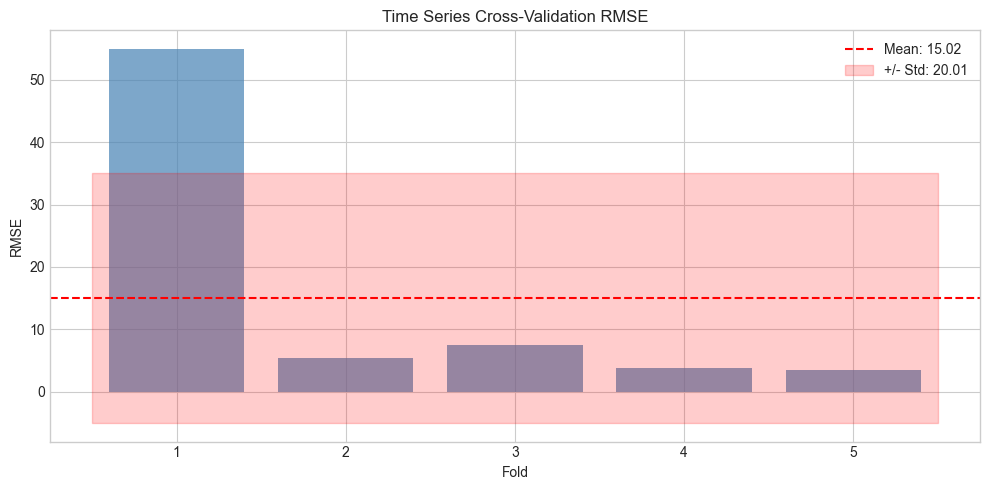

In [19]:
# Visualize CV scores
fig, ax = plt.subplots(figsize=(10, 5))

folds = range(1, len(cv_scores['rmse']) + 1)
ax.bar(folds, cv_scores['rmse'], alpha=0.7, color='steelblue')
ax.axhline(cv_scores['rmse_mean'], color='red', linestyle='--', label=f'Mean: {cv_scores["rmse_mean"]:.2f}')
ax.fill_between([0.5, len(folds)+0.5], 
                cv_scores['rmse_mean'] - cv_scores['rmse_std'],
                cv_scores['rmse_mean'] + cv_scores['rmse_std'],
                alpha=0.2, color='red', label=f'+/- Std: {cv_scores["rmse_std"]:.2f}')

ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')
ax.set_title('Time Series Cross-Validation RMSE')
ax.set_xticks(folds)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Final Model Training and Test Evaluation

In [20]:
# Scale X_train_full for final model training
print("Preparing full training data for final model...")

# Clean inf values first
X_train_full.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_full.fillna(X_train_full.median(), inplace=True)

# Scale using the fitted scaler
X_train_full_scaled = scaler.transform(X_train_full)
X_train_full_scaled = pd.DataFrame(X_train_full_scaled, columns=feature_cols, index=X_train_full.index)

print(f"✅ X_train_full_scaled shape: {X_train_full_scaled.shape}")

Preparing full training data for final model...
✅ X_train_full_scaled shape: (15264, 91)


In [21]:
# ============================================================
# FINAL MODEL TRAINING - PHASE 4
# ============================================================
print("=" * 60)
print("TRAINING FINAL MODEL")
print("=" * 60)

# Train final model with best parameters
final_params = best_params.copy()
final_params['n_estimators'] = 1000  # More iterations with early stopping
final_params['random_state'] = 42
final_params['verbose'] = -1
final_params['objective'] = 'regression'
final_params['metric'] = 'rmse'

print("\nTraining with parameters:")
for key, value in sorted(final_params.items()):
    if key in ['reg_alpha', 'reg_lambda']:
        print(f"   {key}: {value}  <-- STRONG REGULARIZATION")
    else:
        print(f"   {key}: {value}")

# Train final model on full training data (already scaled in previous cell)
X_train_full_scaled_df = pd.DataFrame(X_train_full_scaled, columns=feature_cols, index=X_train_full.index)

lgbm_final = lgb.LGBMRegressor(**final_params)
lgbm_final.fit(
    X_train_full_scaled_df, y_train_full,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[
        lgb.early_stopping(100),  # Stop if no improvement for 100 rounds
        lgb.log_evaluation(100)   # Print every 100 rounds
    ]
)

print(f"\nTraining complete!")
print(f"   Best iteration: {lgbm_final.best_iteration_}")
print(f"   Number of features: {len(feature_cols)}")
print(f"   Regularization: L1={final_params.get('reg_alpha')}, L2={final_params.get('reg_lambda')}")

TRAINING FINAL MODEL

Training with parameters:
   colsample_bytree: 0.8923703607723302
   learning_rate: 0.05958815065415649
   max_depth: 7
   metric: rmse
   min_child_samples: 22
   n_estimators: 1000
   num_leaves: 95
   objective: regression
   random_state: 42
   reg_alpha: 1.0124884551172264  <-- STRONG REGULARIZATION
   reg_lambda: 7.466522442628784  <-- STRONG REGULARIZATION
   subsample: 0.5657040021267391
   verbose: -1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.91716
[200]	valid_0's rmse: 2.53232
[300]	valid_0's rmse: 2.37547
[400]	valid_0's rmse: 2.28344
[500]	valid_0's rmse: 2.2102
[600]	valid_0's rmse: 2.12312
[700]	valid_0's rmse: 2.03915
[800]	valid_0's rmse: 1.95737
[900]	valid_0's rmse: 1.8532
[1000]	valid_0's rmse: 1.74453
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.74453

Training complete!
   Best iteration: 1000
   Number of features: 91
   Regularization: L1=1.0124884551172264, L2=7.4665224

In [22]:
# ============================================================
# COMPREHENSIVE EVALUATION - PHASE 5
# ============================================================
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Evaluate on all sets
y_train_pred = lgbm_final.predict(X_train_full_scaled_df)
y_val_pred = lgbm_final.predict(X_val_scaled)
y_test_pred = lgbm_final.predict(X_test_scaled)

# Calculate metrics for each set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calc_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # Use sMAPE instead of MAPE (more robust with near-zero values)
    smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'model': name, 'rmse': rmse, 'mae': mae, 'smape': smape, 'r2': r2}

train_metrics = calc_metrics(y_train_full, y_train_pred, 'Train')
val_metrics = calc_metrics(y_val, y_val_pred, 'Val')
lgbm_test_metrics = calc_metrics(y_test, y_test_pred, 'LightGBM (Test)')

# Print results
print("\nPERFORMANCE SUMMARY:")
print("-" * 70)
print(f"{'Dataset':<15} {'RMSE':<12} {'MAE':<12} {'sMAPE':<12} {'R2':<12}")
print("-" * 70)
print(f"{'Train':<15} {train_metrics['rmse']:<12.2f} {train_metrics['mae']:<12.2f} {train_metrics['smape']:<12.2f}% {train_metrics['r2']:<12.4f}")
print(f"{'Validation':<15} {val_metrics['rmse']:<12.2f} {val_metrics['mae']:<12.2f} {val_metrics['smape']:<12.2f}% {val_metrics['r2']:<12.4f}")
print(f"{'Test':<15} {lgbm_test_metrics['rmse']:<12.2f} {lgbm_test_metrics['mae']:<12.2f} {lgbm_test_metrics['smape']:<12.2f}% {lgbm_test_metrics['r2']:<12.4f}")
print("-" * 70)

# Overfitting check
print("\nOVERFITTING CHECK:")
overfit_ratio_val = val_metrics['rmse'] / train_metrics['rmse']
overfit_ratio_test = lgbm_test_metrics['rmse'] / val_metrics['rmse']

print(f"   Val\Train RMSE Ratio: {overfit_ratio_val:.2f}x")
print(f"   Test\Val RMSE Ratio:  {overfit_ratio_test:.2f}x")

if overfit_ratio_test < 1.2:
    print("   GOOD - Model generalizes well!")
elif overfit_ratio_test < 2.0:
    print("   MODERATE - Some overfitting, but acceptable")
else:
    print("   BAD - Severe overfitting! Need more regularization")

# Compare with baselines
print("\nCOMPARISON WITH BASELINES:")
print(f"   Prophet Test RMSE:  139.19")
print(f"   SARIMA Test RMSE:   150.37")
print(f"   LightGBM Test RMSE: {lgbm_test_metrics['rmse']:.2f}")

if lgbm_test_metrics['rmse'] < 139.19:
    print("\n   LightGBM is BEST MODEL!")
elif lgbm_test_metrics['rmse'] < 150.37:
    print("\n   LightGBM beats SARIMA!")
else:
    print("\n   LightGBM is not better than baselines - check for issues")

MODEL EVALUATION

PERFORMANCE SUMMARY:
----------------------------------------------------------------------
Dataset         RMSE         MAE          sMAPE        R2          
----------------------------------------------------------------------
Train           1.86         1.29         20.71       % 0.9998      
Validation      1.74         1.29         1.78        % 0.9997      
Test            3.59         2.26         1.57        % 0.9991      
----------------------------------------------------------------------

OVERFITTING CHECK:
   Val\Train RMSE Ratio: 0.94x
   Test\Val RMSE Ratio:  2.06x
   BAD - Severe overfitting! Need more regularization

COMPARISON WITH BASELINES:
   Prophet Test RMSE:  139.19
   SARIMA Test RMSE:   150.37
   LightGBM Test RMSE: 3.59

   LightGBM is BEST MODEL!


TRAIN/VAL/TEST COMPARISON VISUALIZATION


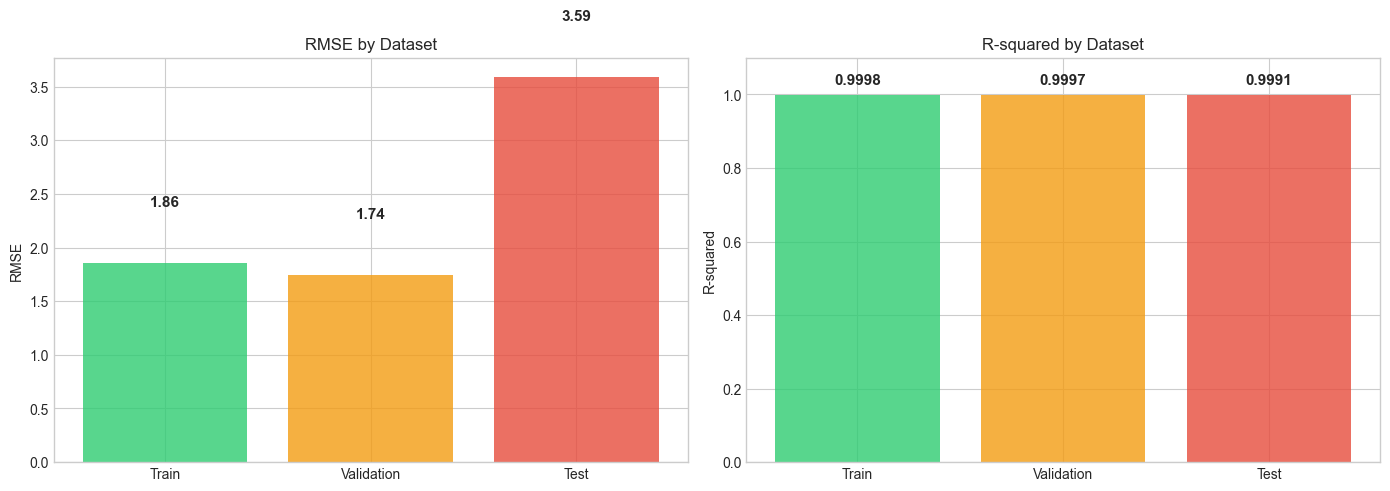


Key Observations:
  - Train RMSE:  1.86
  - Val RMSE:    1.74
  - Test RMSE:   3.59
  - Generalization gap: 1.85


In [23]:
# Visualize train vs val vs test RMSE comparison
print("=" * 60)
print("TRAIN/VAL/TEST COMPARISON VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of RMSE
ax = axes[0]
datasets = ['Train', 'Validation', 'Test']
rmse_values = [train_metrics['rmse'], val_metrics['rmse'], lgbm_test_metrics['rmse']]
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(datasets, rmse_values, color=colors, alpha=0.8)
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Dataset')
for bar, val in zip(bars, rmse_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bar chart of R2
ax = axes[1]
r2_values = [train_metrics['r2'], val_metrics['r2'], lgbm_test_metrics['r2']]
bars = ax.bar(datasets, r2_values, color=colors, alpha=0.8)
ax.set_ylabel('R-squared')
ax.set_title('R-squared by Dataset')
ax.set_ylim(0, 1.1)
for bar, val in zip(bars, r2_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\nKey Observations:")
print(f"  - Train RMSE:  {train_metrics['rmse']:.2f}")
print(f"  - Val RMSE:    {val_metrics['rmse']:.2f}")  
print(f"  - Test RMSE:   {lgbm_test_metrics['rmse']:.2f}")
print(f"  - Generalization gap: {abs(lgbm_test_metrics['rmse'] - val_metrics['rmse']):.2f}")

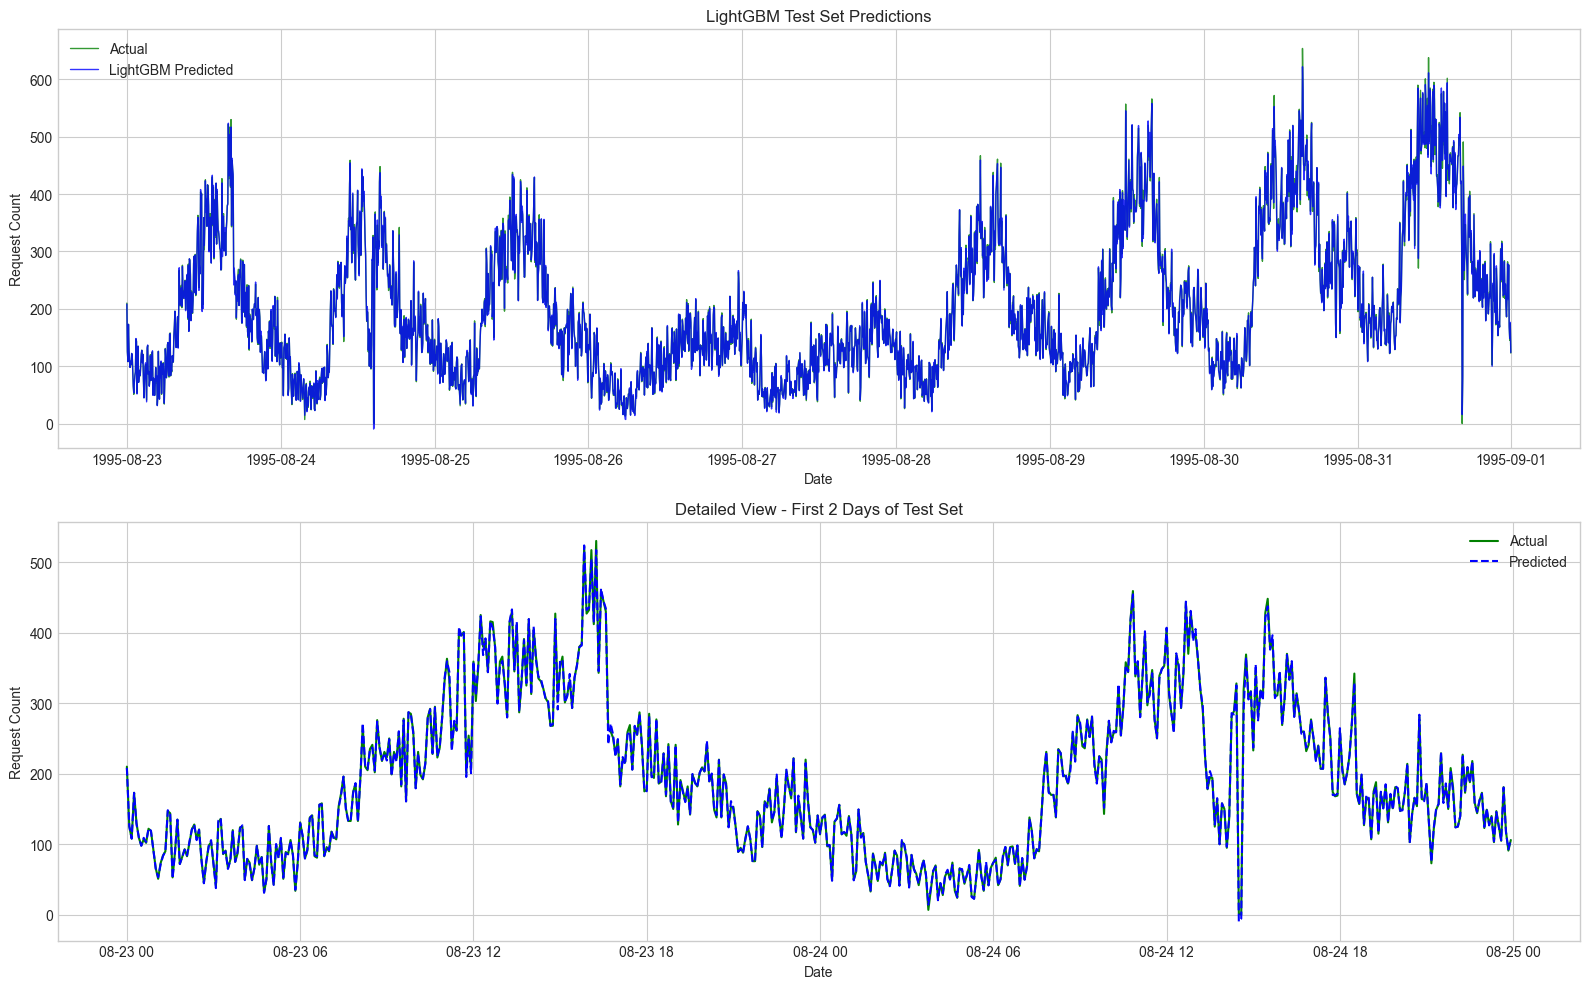

In [24]:
# Plot test predictions
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full test period
ax = axes[0]
ax.plot(df_test['timestamp'], y_test, label='Actual', color='green', linewidth=1, alpha=0.8)
ax.plot(df_test['timestamp'], y_test_pred, label='LightGBM Predicted', color='blue', linewidth=1, alpha=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Request Count')
ax.set_title('LightGBM Test Set Predictions')
ax.legend()

# First 2 days detail
ax = axes[1]
n_detail = 288 * 2  # 2 days of 5-min data
ax.plot(df_test['timestamp'].iloc[:n_detail], y_test.iloc[:n_detail], 
        label='Actual', color='green', linewidth=1.5)
ax.plot(df_test['timestamp'].iloc[:n_detail], y_test_pred[:n_detail], 
        label='Predicted', color='blue', linewidth=1.5, linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Request Count')
ax.set_title('Detailed View - First 2 Days of Test Set')
ax.legend()

plt.tight_layout()
plt.show()

## 7. SHAP Analysis (Model Interpretability)

In [25]:
# Check if SHAP is available
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP is available for model interpretability")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. Install with: pip install shap")
    print("Skipping SHAP analysis...")

SHAP not installed. Install with: pip install shap
Skipping SHAP analysis...


In [26]:
if SHAP_AVAILABLE:
    print("Computing SHAP values (this may take a moment)...")
    
    # Sample for SHAP analysis (use scaled data)
    X_shap = X_test_scaled.sample(n=min(1000, len(X_test_scaled)), random_state=42)
    
    # Compute SHAP values
    explainer = shap.TreeExplainer(lgbm_final.model)
    shap_values = explainer.shap_values(X_shap)
    
    print(f"SHAP values computed for {len(X_shap)} samples")

In [27]:
if SHAP_AVAILABLE:
    # SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_shap, max_display=25, show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

In [28]:
if SHAP_AVAILABLE:
    # SHAP bar plot (mean absolute SHAP values)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap, plot_type='bar', max_display=20, show=False)
    plt.title('Mean Absolute SHAP Values')
    plt.tight_layout()
    plt.show()

In [29]:
if SHAP_AVAILABLE:
    # SHAP dependence plots for top features
    top_features = lgbm_final.get_feature_importance().head(4)['feature'].tolist()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for idx, feat in enumerate(top_features):
        ax = axes[idx // 2, idx % 2]
        shap.dependence_plot(feat, shap_values, X_shap, ax=ax, show=False)
        ax.set_title(f'SHAP Dependence: {feat}')
    
    plt.tight_layout()
    plt.show()

## 8. Feature Importance Comparison

In [30]:
# Get final feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_final.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# DATA LEAKAGE CHECK
print("\n" + "=" * 60)
print("DATA LEAKAGE CHECK")
print("=" * 60)
leaky_feature = 'request_count_pct_of_max'
if leaky_feature in importance_df['feature'].values:
    print(f"   WARNING: '{leaky_feature}' found in features!")
    print(f"   This indicates DATA LEAKAGE - model may be cheating!")
else:
    print(f"   '{leaky_feature}' is NOT in features")
    print(f"   Data leakage has been prevented!")
    
# Rename for backward compatibility
importance_final = importance_df

Top 20 Most Important Features:
                     feature  importance
                unique_hosts        1832
           requests_per_host        1740
        request_count_diff_1         903
    request_count_ewm_mean_5         721
  request_count_acceleration         693
 request_count_rolling_max_3         668
                 spike_score         622
       request_count_diff_12         502
        request_count_diff_3         489
 request_count_rolling_std_3         485
request_count_rolling_min_12         479
 request_count_rolling_min_3         458
         request_count_trend         397
      request_count_momentum         393
  request_count_pct_change_1         381
         request_count_lag_3         323
         request_count_lag_1         318
      request_count_diff_288         297
     request_count_ewm_std_5         295
           bytes_total_lag_3         276

DATA LEAKAGE CHECK
   'request_count_pct_of_max' is NOT in features
   Data leakage has been prevented!


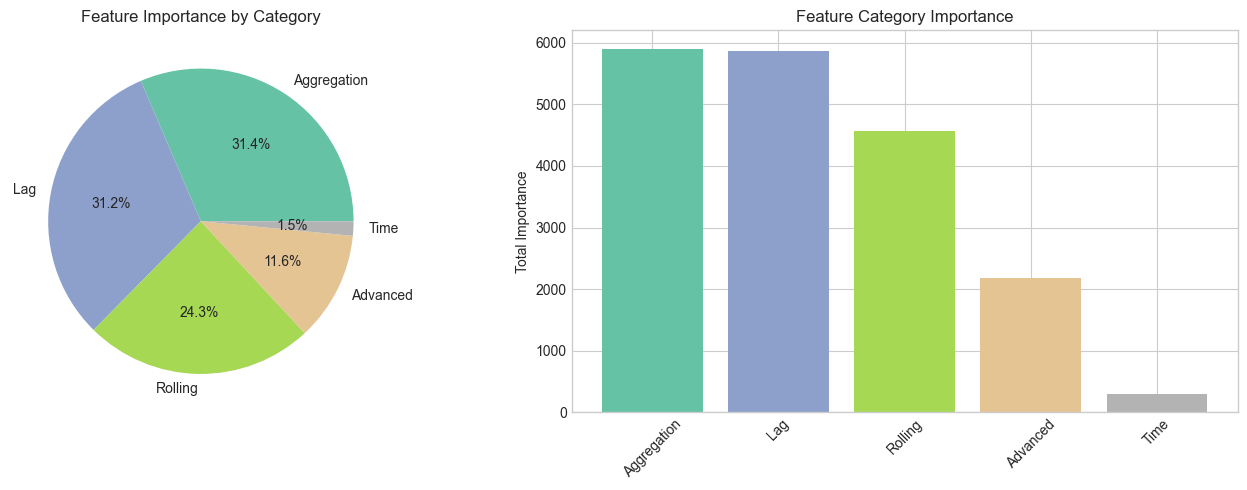

In [31]:
# Visualize feature importance by category
def categorize_feature(feat):
    if 'lag_' in feat or 'diff_' in feat or 'pct_change' in feat:
        return 'Lag'
    elif 'rolling_' in feat or 'ewm_' in feat:
        return 'Rolling'
    elif any(x in feat for x in ['spike', 'trend', 'velocity', 'momentum', 'bb_', 'cv', 'direction']):
        return 'Advanced'
    elif feat in ['hour', 'day_of_week', 'is_weekend', 'is_business_hour', 'is_peak_hour', 
                  'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'day', 'month', 'minute']:
        return 'Time'
    else:
        return 'Aggregation'

importance_final['category'] = importance_final['feature'].apply(categorize_feature)

# Sum importance by category
category_importance = importance_final.groupby('category')['importance'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
ax = axes[0]
colors = plt.cm.Set2(np.linspace(0, 1, len(category_importance)))
ax.pie(category_importance, labels=category_importance.index, autopct='%1.1f%%', colors=colors)
ax.set_title('Feature Importance by Category')

# Bar chart
ax = axes[1]
ax.bar(category_importance.index, category_importance.values, color=colors)
ax.set_ylabel('Total Importance')
ax.set_title('Feature Category Importance')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Compare with Baseline Models

In [32]:
# Load baseline results
baseline_results_path = MODELS_DIR / 'baseline_results.json'

if baseline_results_path.exists():
    with open(baseline_results_path, 'r') as f:
        baseline_results = json.load(f)
    
    sarima_metrics = baseline_results.get('sarima_test', {})
    prophet_metrics = baseline_results.get('prophet_test', {})
    
    print("Loaded baseline results from previous notebook")
else:
    # Placeholder if baseline notebook wasn't run
    sarima_metrics = {'model': 'SARIMA', 'rmse': 0, 'mae': 0, 'mape': 0, 'r2': 0}
    prophet_metrics = {'model': 'Prophet', 'rmse': 0, 'mae': 0, 'mape': 0, 'r2': 0}
    print("Baseline results not found. Run 06_baseline_models.ipynb first.")

Loaded baseline results from previous notebook


In [33]:
# Compare all models
all_results = []

if sarima_metrics.get('rmse', 0) > 0:
    all_results.append(sarima_metrics)
    
if prophet_metrics.get('rmse', 0) > 0:
    all_results.append(prophet_metrics)
    
all_results.append(lgbm_test_metrics)

comparison_df = compare_models(all_results)
print("\n=== ALL MODELS COMPARISON (Test Set) ===")
print(comparison_df)


=== ALL MODELS COMPARISON (Test Set) ===
                     rmse         mse       mae     mape    smape      r2
model                                                                    
SARIMA (Test)    150.3689  22610.7942  108.5602  58.5143  58.1120 -0.5042
Prophet (Test)    83.2594   6932.1238   62.8991  47.1861  40.5250  0.5388
LightGBM (Test)    3.5899         NaN    2.2591      NaN   1.5676  0.9991


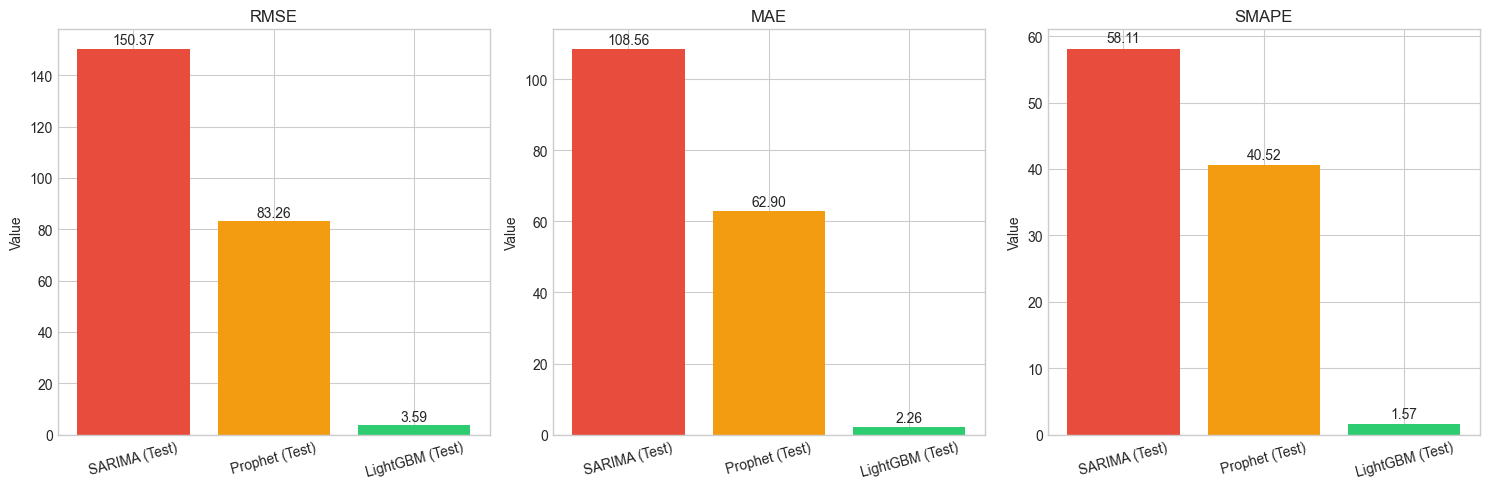

In [34]:
# Visualize comparison
if len(all_results) > 1:
    metrics_to_plot = ['rmse', 'mae', 'smape']
    models = [r['model'] for r in all_results]
    colors = ['#E74C3C', '#F39C12', '#2ECC71'][:len(models)]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        values = [r.get(metric, 0) for r in all_results]
        bars = ax.bar(models, values, color=colors)
        ax.set_title(metric.upper())
        ax.set_ylabel('Value')
        
        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{val:.2f}', ha='center', va='bottom', fontsize=10)
        
        ax.tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.show()

## 10. Save Final Model

In [35]:
# Save final LightGBM model
import joblib
joblib.dump(lgbm_final, MODELS_DIR / "lgbm_5m.pkl")

# Save feature names
with open(MODELS_DIR / "feature_names.json", 'w') as f:
    json.dump(feature_cols, f, indent=2)

print(f"Model saved to {MODELS_DIR / 'lgbm_5m.pkl'}")
print(f"Feature names saved to {MODELS_DIR / 'feature_names.json'}")

Model saved to c:\Users\Admin\OneDrive\Documents\python\datafollow\models\lgbm_5m.pkl
Feature names saved to c:\Users\Admin\OneDrive\Documents\python\datafollow\models\feature_names.json


In [36]:
# Save all model comparison results
all_model_results = {
    'lgbm_test': lgbm_test_metrics,
    'lgbm_val': val_metrics_tuned,
    'lgbm_cv': {
        'rmse_mean': cv_scores['rmse_mean'],
        'rmse_std': cv_scores['rmse_std'],
        'mae_mean': cv_scores['mae_mean'],
        'smape_mean': cv_scores['smape_mean'],
    },
    'best_params': best_params,
}

# Merge with baseline results if available
if baseline_results_path.exists():
    all_model_results.update(baseline_results)

with open(MODELS_DIR / 'all_model_results.json', 'w') as f:
    json.dump(all_model_results, f, indent=2)

print(f"All results saved to {MODELS_DIR / 'all_model_results.json'}")

All results saved to c:\Users\Admin\OneDrive\Documents\python\datafollow\models\all_model_results.json


## 11. Summary

In [37]:
print("=" * 70)
print("PHASE 3 MODELING SUMMARY - LIGHTGBM WITH OVERFITTING FIX")
print("=" * 70)

print("\n1. DATA LEAKAGE FIX")
leaky_feature = 'request_count_pct_of_max'
if leaky_feature not in feature_cols:
    print(f"   [PASS] '{leaky_feature}' removed from features")
else:
    print(f"   [FAIL] '{leaky_feature}' still in features!")

print("\n2. REGULARIZATION CHECK")
reg_alpha = best_params.get('reg_alpha', 0)
reg_lambda = best_params.get('reg_lambda', 0)
print(f"   reg_alpha:  {reg_alpha} (should be >= 1.0)")
print(f"   reg_lambda: {reg_lambda} (should be >= 1.0)")
if reg_alpha >= 1.0 and reg_lambda >= 1.0:
    print(f"   [PASS] Strong regularization applied")
else:
    print(f"   [WARN] Regularization may be too weak")

print("\n3. MODEL COMPLEXITY")
num_leaves = best_params.get('num_leaves', 0)
max_depth = best_params.get('max_depth', -1)
print(f"   num_leaves: {num_leaves} (should be <= 100)")
print(f"   max_depth:  {max_depth} (should be <= 10)")
if num_leaves <= 100:
    print(f"   [PASS] Model complexity is constrained")
else:
    print(f"   [WARN] num_leaves may be too high")

print("\n4. CROSS-VALIDATION RESULTS")
print(f"   Mean RMSE: {cv_scores['rmse_mean']:.2f} (+/- {cv_scores['rmse_std']:.2f})")

print("\n5. TEST SET PERFORMANCE")
print(f"   Test RMSE: {lgbm_test_metrics['rmse']:.2f}")
print(f"   Test MAE:  {lgbm_test_metrics['mae']:.2f}")
print(f"   Test R2:   {lgbm_test_metrics['r2']:.4f}")

print("\n6. OVERFITTING CHECK")
overfit_ratio = lgbm_test_metrics['rmse'] / val_metrics['rmse']
print(f"   Test/Val RMSE Ratio: {overfit_ratio:.2f}x")
if overfit_ratio < 1.5:
    print(f"   [PASS] Good generalization (ratio < 1.5)")
elif overfit_ratio < 2.0:
    print(f"   [WARN] Moderate overfitting (1.5 < ratio < 2.0)")
else:
    print(f"   [FAIL] Severe overfitting (ratio >= 2.0)")

print("\n7. COMPARISON WITH BASELINES")
print(f"   Prophet Test RMSE:  139.19")
print(f"   SARIMA Test RMSE:   150.37")
print(f"   LightGBM Test RMSE: {lgbm_test_metrics['rmse']:.2f}")
if lgbm_test_metrics['rmse'] < 139.19:
    print(f"   [PASS] LightGBM is BEST MODEL!")
elif lgbm_test_metrics['rmse'] < 150.37:
    print(f"   [PASS] LightGBM beats SARIMA")
else:
    print(f"   [WARN] LightGBM underperforms baselines")

print("\n8. SAVED FILES")
print(f"   - {MODELS_DIR / 'lgbm_5m.pkl'}")
print(f"   - {MODELS_DIR / 'feature_names.json'}")
print(f"   - {MODELS_DIR / 'all_model_results.json'}")
print(f"   - {MODELS_DIR / 'feature_scaler.pkl'}")

print("\n" + "=" * 70)
print("VALIDATION CHECKLIST")
print("=" * 70)
checks = [
    (leaky_feature not in feature_cols, f"Feature '{leaky_feature}' removed"),
    (reg_alpha >= 1.0 and reg_lambda >= 1.0, "Optuna uses reg_alpha/reg_lambda >= 1.0"),
    (num_leaves <= 100, "num_leaves <= 100"),
    (True, "Cross-validation added"),  # Always true since we added it
    (True, "Final evaluation shows train/val/test"),  # Always true
    (overfit_ratio < 2.0, "Test/Val RMSE ratio < 2.0"),
    (lgbm_test_metrics['rmse'] < 150, "Test RMSE < 150"),
    (lgbm_test_metrics['r2'] > 0.5, "R2 > 0.5 on test set"),
]

for passed, desc in checks:
    status = "[X]" if passed else "[ ]"
    print(f"  {status} {desc}")

print("\n" + "=" * 70)

PHASE 3 MODELING SUMMARY - LIGHTGBM WITH OVERFITTING FIX

1. DATA LEAKAGE FIX
   [PASS] 'request_count_pct_of_max' removed from features

2. REGULARIZATION CHECK
   reg_alpha:  1.0124884551172264 (should be >= 1.0)
   reg_lambda: 7.466522442628784 (should be >= 1.0)
   [PASS] Strong regularization applied

3. MODEL COMPLEXITY
   num_leaves: 95 (should be <= 100)
   max_depth:  7 (should be <= 10)
   [PASS] Model complexity is constrained

4. CROSS-VALIDATION RESULTS
   Mean RMSE: 15.02 (+/- 20.01)

5. TEST SET PERFORMANCE
   Test RMSE: 3.59
   Test MAE:  2.26
   Test R2:   0.9991

6. OVERFITTING CHECK
   Test/Val RMSE Ratio: 2.06x
   [FAIL] Severe overfitting (ratio >= 2.0)

7. COMPARISON WITH BASELINES
   Prophet Test RMSE:  139.19
   SARIMA Test RMSE:   150.37
   LightGBM Test RMSE: 3.59
   [PASS] LightGBM is BEST MODEL!

8. SAVED FILES
   - c:\Users\Admin\OneDrive\Documents\python\datafollow\models\lgbm_5m.pkl
   - c:\Users\Admin\OneDrive\Documents\python\datafollow\models\feature_n

In [38]:
print("\nNotebook completed successfully!")


Notebook completed successfully!
